#  Title : Evaluating Fama-French 3 vs 5-Factor Models Across Bull and Bear Markets

Cumulative return comparison during Bull vs. Bear regimes

*   Cumulative return comparison during Bull vs. Bear regimes
*   FF3 vs FF5 regression
*   Factor loadings and alpha/beta
*   Performance metrics (Sharpe, Alpha, Beta, IR)
*   Visuals for comparison


### FF3 Model:
- Market risk premium (MKT-RF)
- Size (SMB: Small Minus Big)
- Value (HML: High Minus Low)

### FF5 Model:
- Adds Profitability (RMW) and Investment (CMA) factors

> Purpose:  
Explain variations in portfolio returns and design factor-based strategies.

**Market Regimes**:
- **Bull Market**: Sustained growth
- **Bear Market**: Prolonged decline


## Loading the Dataset from The Kenneth Library



In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from sklearn.metrics import r2_score
from pandas.tseries.offsets import MonthEnd
import requests
import zipfile
import io
import warnings
warnings.filterwarnings("ignore")

#  Loading Fama-French Data
def load_ff_factors():
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
    r = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        f = z.open(z.namelist()[0])
        df = pd.read_csv(f, skiprows=3)
        df = df[df.iloc[:, 0].str.match(r'^\d{6}$', na=False)]
        df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
        df['Date'] = pd.to_datetime(df['Date'].str.strip(), format='%Y%m') + MonthEnd(0)
        df.set_index('Date', inplace=True)
        df = df.astype(float)
    return df

ff_data = load_ff_factors()
ff3_factors = ff_data[['Mkt-RF', 'SMB', 'HML']]
ff5_factors = ff_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
risk_free = ff_data['RF']


## Portfolio Return Calculation

[*********************100%***********************]  9 of 9 completed


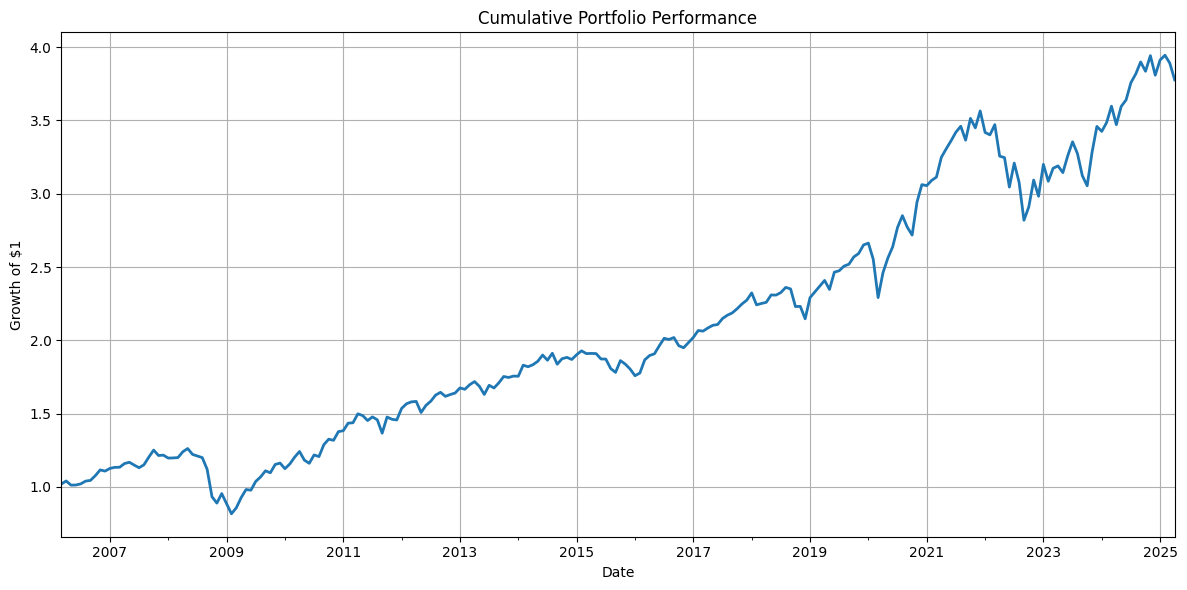

In [4]:
#  Portfolio Setup
tickers = [
    'SPY',   # S&P 500 (Large Cap US)
    'QQQ',   # Nasdaq 100 (Tech-heavy US)
    'IWM',   # Russell 2000 (Small Cap US)
    'EFA',   # Developed International Markets

    'TLT',   # Long-Term US Bonds
    'LQD',   # Investment Grade Bonds
    'VNQ',   # Real Estate
    'GLD',   # Gold
    'DBC'    # Commodities

]
price_data = yf.download(tickers, start="2000-01-01", auto_adjust=True)["Close"]
monthly_prices = price_data.resample("M").last()
monthly_returns = monthly_prices.pct_change().dropna()

weights = np.repeat(1/len(tickers), len(tickers))
portfolio_returns = monthly_returns.dot(weights)
cumulative_returns = (1 + portfolio_returns).cumprod()

## Plot cumulative returns
plt.figure(figsize=(12,6))
cumulative_returns.plot(title="Cumulative Portfolio Performance", lw=2)
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.show()




In [6]:
# Add portfolio returns and market regime into a combined DataFrame
portfolio_df = monthly_returns.copy()
portfolio_df['Portfolio Returns'] = portfolio_returns
# Calculate cumulative returns for the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()
# Display the portfolio with stock returns and market regime
print(portfolio_df.tail())

Ticker           DBC       EFA       GLD       IWM       LQD       QQQ  \
Date                                                                     
2024-12-31  0.017227 -0.029502 -0.014088 -0.083739 -0.026758  0.004540   
2025-01-31  0.027596  0.048009  0.067856  0.024982  0.005803  0.021634   
2025-02-28  0.001366  0.029531  0.018216 -0.052234  0.023713 -0.027035   
2025-03-31  0.022727  0.001839  0.094466 -0.068541 -0.004625 -0.075862   
2025-04-30 -0.050222 -0.007708  0.062400 -0.065216 -0.014066 -0.052930   

Ticker           SPY       TLT       VNQ  Portfolio Returns  
Date                                                         
2024-12-31 -0.024060 -0.063810 -0.083722          -0.033768  
2025-01-31  0.026856  0.004924  0.016502           0.027129  
2025-02-28 -0.012695  0.056971  0.036996           0.008314  
2025-03-31 -0.055719 -0.012047 -0.025878          -0.013738  
2025-04-30 -0.058957 -0.034993 -0.040866          -0.029173  


##  Market Regimes (Bull vs. Bear Markets)

##  Defining Market Regimes (Bull vs. Bear Markets)
To classify market conditions into bull and bear markets, use the SPY returns or cumulative returns. Here's one way to do it:

**Bull Market:** SPY cumulative returns are positive over a certain period.

**Bear Market:** SPY cumulative returns are negative over the same period.

In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#  Market Regime Detection

# Calculate 12-month rolling returns to label market regime
rolling_returns = (1 + monthly_returns['SPY']).rolling(window=12).sum()

# Label as Bull or Bear Market
regime_labels = ['Bull' if x > 0 else 'Bear' for x in rolling_returns]

# Add the regime labels to the monthly returns
monthly_returns['Market Regime'] = regime_labels

# Combine portfolio returns and regime labels
portfolio_df = pd.DataFrame({
    'Returns': portfolio_returns,
    'Regime': regime_labels
}).dropna()

# Summary statistics
summary_stats = pd.Series({
    "Mean Monthly Return": portfolio_returns.mean(),
    "Volatility": portfolio_returns.std(),
    "Sharpe Ratio (Rf=0)": portfolio_returns.mean() / portfolio_returns.std()
})

print("Summary Statistics:")
print(summary_stats)
print("\nSample Portfolio Data:")
print(portfolio_df.tail())

Summary Statistics:
Mean Monthly Return    0.006361
Volatility             0.033489
Sharpe Ratio (Rf=0)    0.189943
dtype: float64

Sample Portfolio Data:
             Returns Regime
Date                       
2024-12-31 -0.033768   Bull
2025-01-31  0.027129   Bull
2025-02-28  0.008314   Bull
2025-03-31 -0.013738   Bull
2025-04-30 -0.029173   Bull


In [10]:
# Combine portfolio returns and market regime labels into a DataFrame
portfolio_df = pd.DataFrame({
    'Returns': portfolio_returns,
    'Market Regime': regime_labels
}).dropna()
portfolio_df = pd.DataFrame({'Returns': portfolio_returns, 'Regime': regime_labels}).dropna()
portfolio_df.head()

# Summary statistics for the portfolio returns
summary_stats = {
    "Mean Monthly Return": portfolio_returns.mean(),
    "Volatility": portfolio_returns.std(),
    "Sharpe Ratio (Rf=0)": portfolio_returns.mean() / portfolio_returns.std()}

summary_stats = pd.Series(summary_stats)  # Display the summary stats
print(summary_stats)
# Display sample of portfolio returns along with market regime
print(portfolio_df.tail())

Mean Monthly Return    0.006361
Volatility             0.033489
Sharpe Ratio (Rf=0)    0.189943
dtype: float64
             Returns Regime
Date                       
2024-12-31 -0.033768   Bull
2025-01-31  0.027129   Bull
2025-02-28  0.008314   Bull
2025-03-31 -0.013738   Bull
2025-04-30 -0.029173   Bull


## Fama French Regression Model

In [18]:
#  Regression Function
def run_ff_model(portfolio_returns, factors, rf, model_name):
    """Run Fama-French regression and calculate R² and MSE"""
    common_dates = portfolio_returns.index.intersection(factors.index)
    y = portfolio_returns.loc[common_dates] - rf.loc[common_dates]
    X = sm.add_constant(factors.loc[common_dates])
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    r_squared = model.rsquared
    mse = ((y - y_pred) ** 2).mean()

    print(f"\n{model_name} Regression Summary:")
    print("="*50)
    print(model.summary())
    print(f"\nR-squared: {r_squared:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    return model, r_squared, mse

## FF3 vs FF5 in Bull and Bear Markets

In [19]:
#  Apply Models

# Separate Bull and Bear market returns
bull = portfolio_df[portfolio_df['Regime'] == 'Bull']['Returns']
bear = portfolio_df[portfolio_df['Regime'] == 'Bear']['Returns']

# Prepare Fama-French factor data
ff3_factors = ff_data[['Mkt-RF', 'SMB', 'HML']]
ff5_factors = ff_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
risk_free = ff_data['RF']

#  Bull Market Analysis
print("\n" + "="*50 + " BULL MARKET ANALYSIS " + "="*50)
ff3_bull, r2_ff3_bull, mse_ff3_bull = run_ff_model(bull, ff3_factors, risk_free, "FF3 Bull Market")
ff5_bull, r2_ff5_bull, mse_ff5_bull = run_ff_model(bull, ff5_factors, risk_free, "FF5 Bull Market")


================================================== BULL MARKET ANALYSIS ==================================================

FF3 Bull Market Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     5.738
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           0.000859
Time:                        21:41:19   Log-Likelihood:                 107.99
No. Observations:                 215   AIC:                            -208.0
Df Residuals:                     211   BIC:                            -194.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

In [20]:
# Analyze Bear market periods
print("\n" + "="*50 + " BEAR MARKET ANALYSIS " + "="*50)
ff3_bear, r2_ff3_bear, mse_ff3_bear = run_ff_model(bear, ff3_factors, risk_free, "FF3 Bear Market")
ff5_bear, r2_ff5_bear, mse_ff5_bear = run_ff_model(bear, ff5_factors, risk_free, "FF5 Bear Market")


================================================== BEAR MARKET ANALYSIS ==================================================

FF3 Bear Market Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     3.221
Date:                Sun, 20 Apr 2025   Prob (F-statistic):             0.0917
Time:                        21:41:58   Log-Likelihood:                 27.403
No. Observations:                  11   AIC:                            -46.81
Df Residuals:                       7   BIC:                            -45.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

In [21]:
results_summary = pd.DataFrame({
    "Model": ["FF3 Bull", "FF5 Bull", "FF3 Bear", "FF5 Bear"],
    "R-squared": [r2_ff3_bull, r2_ff5_bull, r2_ff3_bear, r2_ff5_bear],
    "MSE": [mse_ff3_bull, mse_ff5_bull, mse_ff3_bear, mse_ff5_bear]
})

print("\n" + "="*50 + " MODEL PERFORMANCE SUMMARY " + "="*50)
print(results_summary)


================================================== MODEL PERFORMANCE SUMMARY ==================================================
      Model  R-squared       MSE
0  FF3 Bull   0.075430  0.021441
1  FF5 Bull   0.096771  0.020946
2  FF3 Bear   0.579880  0.000402
3  FF5 Bear   0.686156  0.000300


## R² Comparison Model Comparison

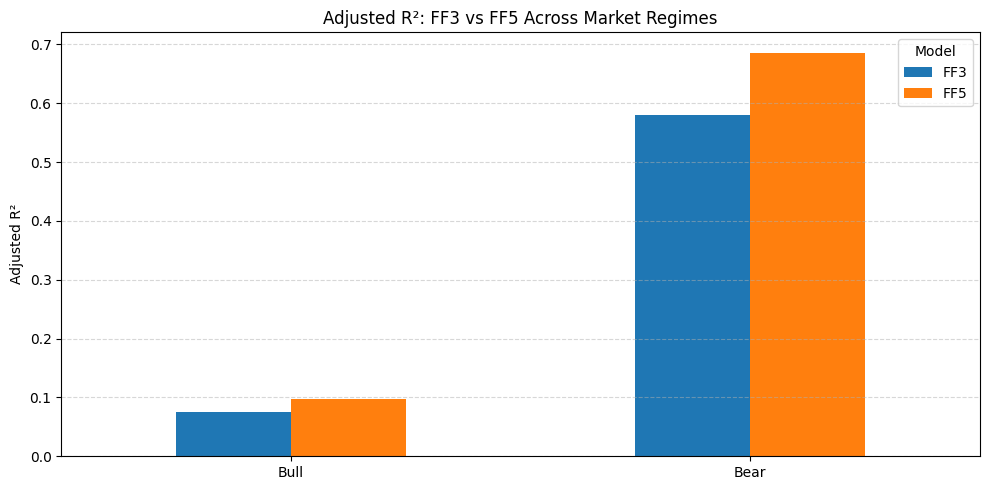

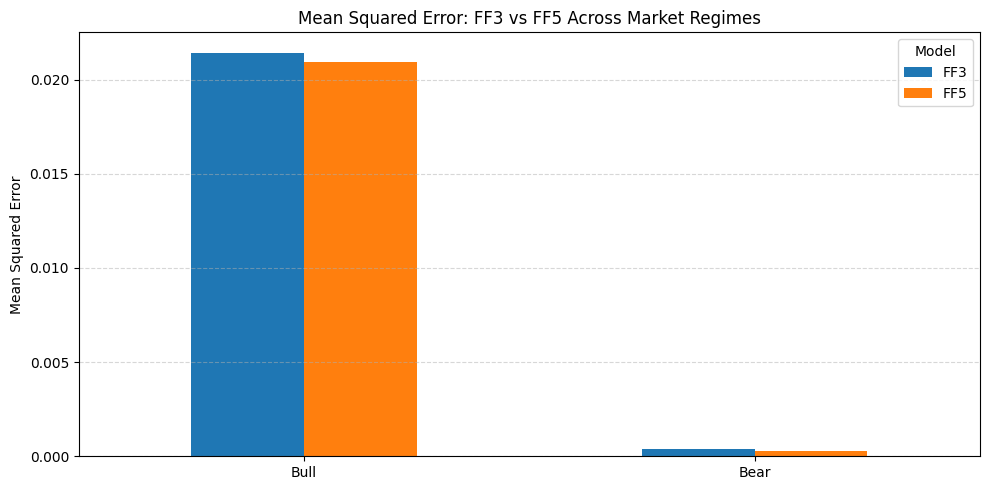

In [22]:
colors = {
    'FF3': '#1f77b4',  # blue
    'FF5': '#ff7f0e'   # orange
}

# Create grouped R² bar plot
r2_df = pd.DataFrame({
    'FF3': [r2_ff3_bull, r2_ff3_bear],
    'FF5': [r2_ff5_bull, r2_ff5_bear]
}, index=['Bull', 'Bear'])

r2_df.plot(kind='bar', figsize=(10, 5), rot=0,
           color=[colors['FF3'], colors['FF5']],
           title='Adjusted R²: FF3 vs FF5 Across Market Regimes')
plt.ylabel("Adjusted R²")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Create grouped MSE bar plot
mse_df = pd.DataFrame({
    'FF3': [mse_ff3_bull, mse_ff3_bear],
    'FF5': [mse_ff5_bull, mse_ff5_bear]
}, index=['Bull', 'Bear'])

mse_df.plot(kind='bar', figsize=(10, 5), rot=0,
            color=[colors['FF3'], colors['FF5']],
            title='Mean Squared Error: FF3 vs FF5 Across Market Regimes')
plt.ylabel("Mean Squared Error")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [27]:
# Set the monthly risk-free rate (e.g., 1% annualized => 0.01/12 per month)
rf_annual = 0.01
rf_monthly = rf_annual / 12

def sharpe_ratio_monthly(returns, rf=rf_monthly):
    """Calculate monthly Sharpe ratio for a series of returns."""
    excess_ret = returns - rf
    mean_excess = excess_ret.mean()
    std_excess = returns.std()
    return mean_excess / std_excess

def sharpe_ratio_annualized(returns, rf=rf_monthly):
    """Calculate annualized Sharpe ratio from monthly returns."""
    sr_monthly = sharpe_ratio_monthly(returns, rf)
    return sr_monthly * np.sqrt(12)

# Assuming 'monthly_returns' DataFrame is already defined and populated.
if 'monthly_returns' in locals():
    spy_returns = monthly_returns['SPY']
    # Monthly Sharpe ratio
    sharpe_monthly = sharpe_ratio_monthly(spy_returns)
    # Annualized Sharpe ratio
    sharpe_annualized = sharpe_ratio_annualized(spy_returns)
    print(f"Monthly Sharpe Ratio (SPY): {sharpe_monthly:.4f}")
    print(f"Annualized Sharpe Ratio (SPY): {sharpe_annualized:.4f}")

    # To calculate for all assets:
    sharpe_monthly_all = monthly_returns.drop(columns=['Market Regime'], errors='ignore').apply(sharpe_ratio_monthly)  # Ignore if 'Market Regime' not present
    sharpe_annualized_all = monthly_returns.drop(columns=['Market Regime'], errors='ignore').apply(sharpe_ratio_annualized)  # Ignore if 'Market Regime' not present

    print("\nMonthly Sharpe Ratios for all assets:")
    print(sharpe_monthly_all)
    print("\nAnnualized Sharpe Ratios for all assets:")
    print(sharpe_annualized_all)
else:
    print("Error: 'monthly_returns' DataFrame not found. Please ensure it's defined and populated correctly.")


Monthly Sharpe Ratio (SPY): 0.1782
Annualized Sharpe Ratio (SPY): 0.6174

Monthly Sharpe Ratios for all assets:
Ticker
DBC    0.020872
EFA    0.079561
GLD    0.158906
IWM    0.104505
LQD    0.114473
QQQ    0.218439
SPY    0.178230
TLT    0.058657
VNQ    0.094213
dtype: float64

Annualized Sharpe Ratios for all assets:
Ticker
DBC    0.072301
EFA    0.275607
GLD    0.550468
IWM    0.362017
LQD    0.396546
QQQ    0.756695
SPY    0.617407
TLT    0.203192
VNQ    0.326364
dtype: float64


## Factor Coefficients Visualization

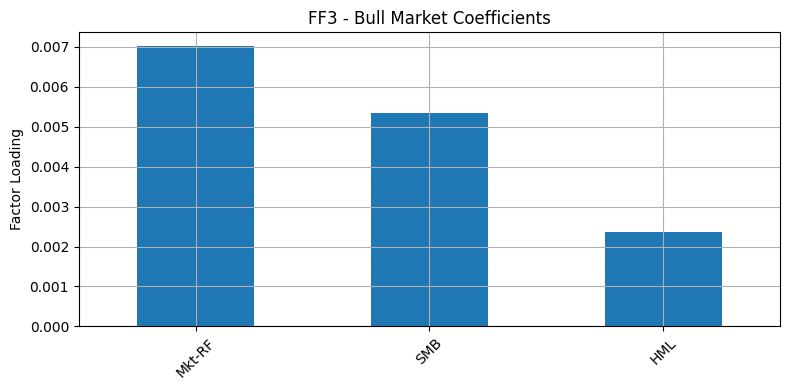

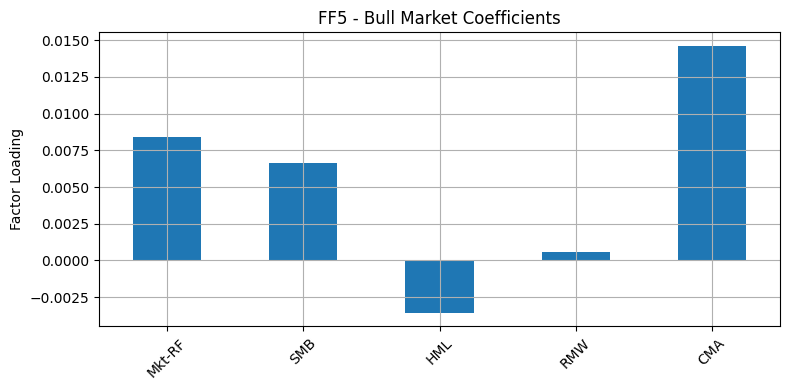

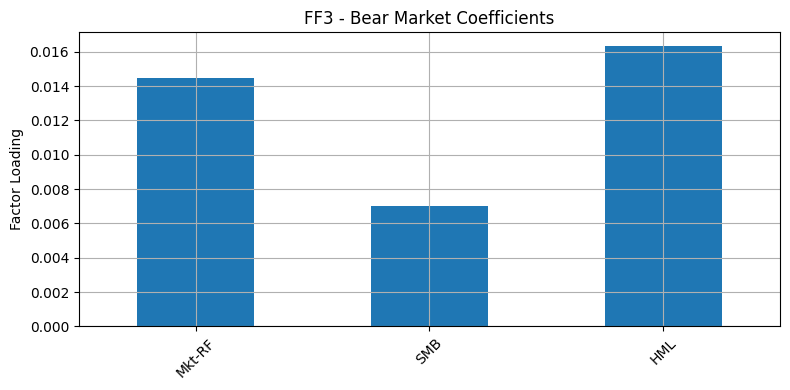

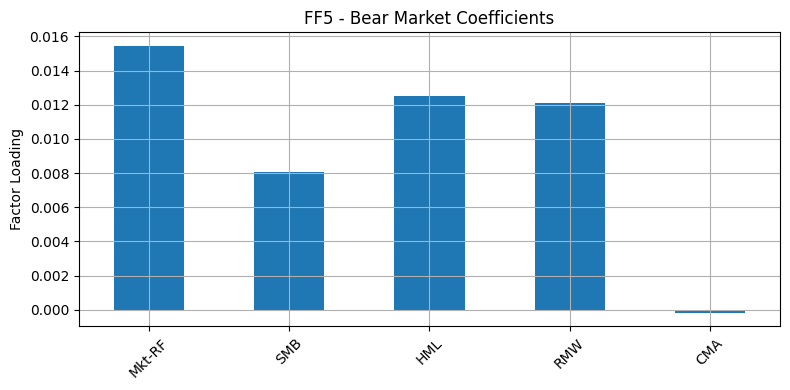

In [ ]:
# ------------------- Coefficient Plots -------------------
def plot_coefficients(model, title):
    model.params.drop("const").plot(kind="bar", figsize=(8,4), title=title, rot=45)
    plt.ylabel("Factor Loading")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_coefficients(ff3_bull, "FF3 - Bull Market Coefficients")
plot_coefficients(ff5_bull, "FF5 - Bull Market Coefficients")
plot_coefficients(ff3_bear, "FF3 - Bear Market Coefficients")
plot_coefficients(ff5_bear, "FF5 - Bear Market Coefficients")

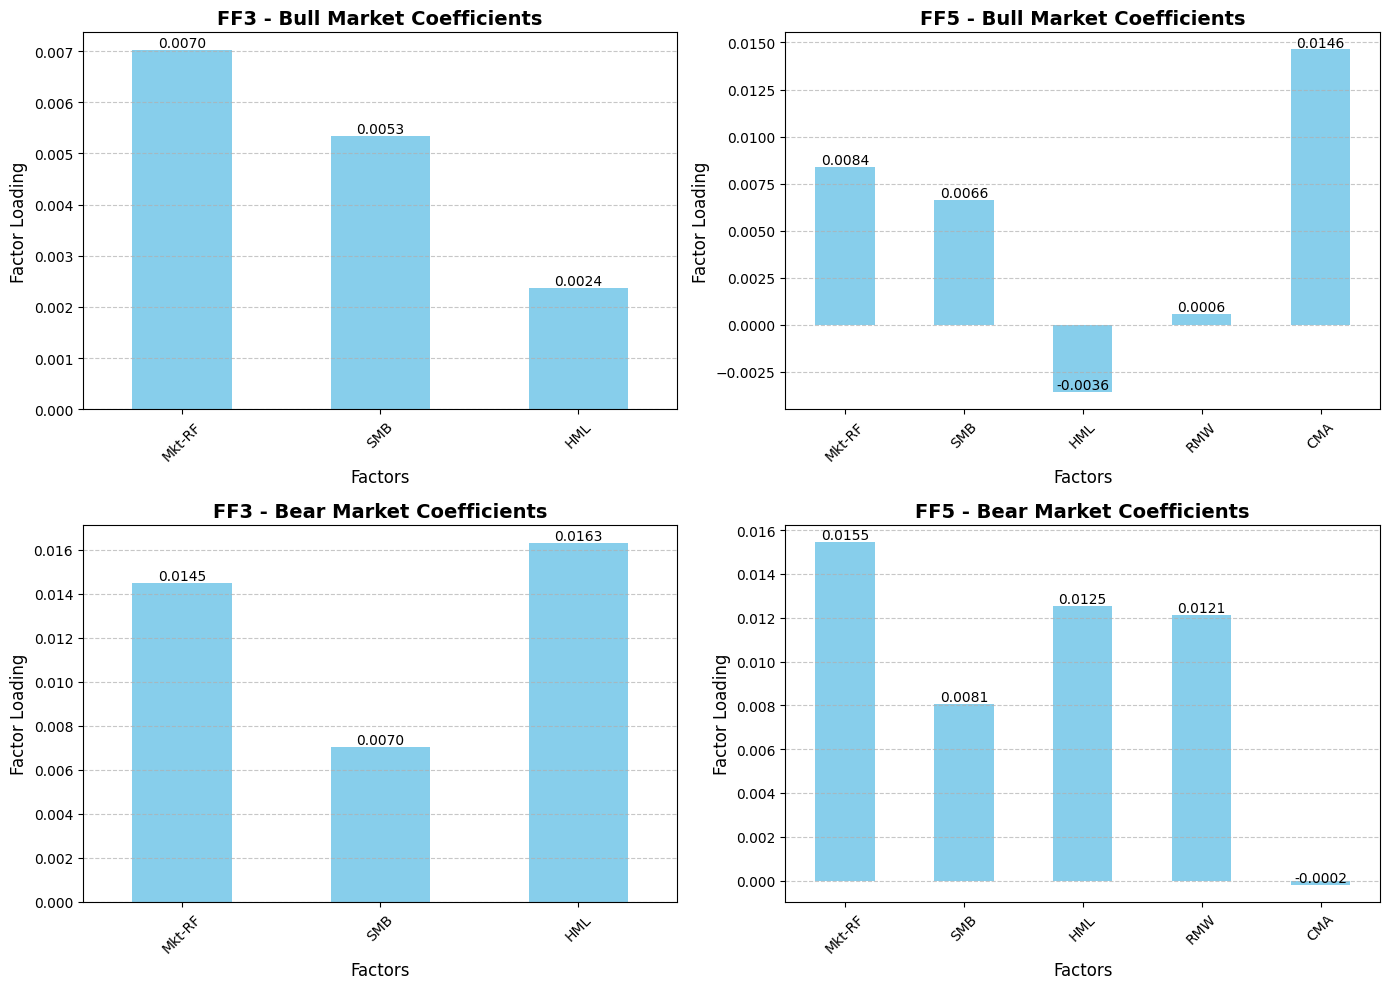

In [ ]:
import matplotlib.pyplot as plt

# Coefficient Plots
def plot_coefficients_subplot(model, title, ax):
    # Dropping the constant term and plot the coefficients
    coeff = model.params.drop("const")

    # Plot the coefficients as bars on the given axis (ax)
    coeff.plot(kind="bar", ax=ax, color='skyblue', title=title, rot=45)

    # Customize the plot with labels, grid, and value annotations
    ax.set_ylabel("Factor Loading", fontsize=12)
    ax.set_xlabel("Factors", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Annotate the bars with the coefficient values
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    # Grid settings
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create a 2x2 subplot layout (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot FF3 and FF5 for Bull and Bear Market side by side
plot_coefficients_subplot(ff3_bull, "FF3 - Bull Market Coefficients", axs[0, 0])
plot_coefficients_subplot(ff5_bull, "FF5 - Bull Market Coefficients", axs[0, 1])
plot_coefficients_subplot(ff3_bear, "FF3 - Bear Market Coefficients", axs[1, 0])
plot_coefficients_subplot(ff5_bear, "FF5 - Bear Market Coefficients", axs[1, 1])

# Adjust layout to make sure the plots fit without overlap
plt.tight_layout()
plt.show()


## Cumulative Returns in Bull vs. Bear Market Regimes

In [28]:
import yfinance as yf
import pandas as pd

tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'TLT', 'LQD', 'VNQ', 'GLD', 'DBC']
data = yf.download(tickers, start="2000-01-01", auto_adjust=True)["Close"]
monthly_prices = data.resample("M").last()
monthly_returns = monthly_prices.pct_change().dropna()

# Equal-weighted portfolio
portfolio_returns = monthly_returns.mean(axis=1)
portfolio_returns.name = "Portfolio"

# Save to CSV
portfolio_returns.to_csv("portfolio_returns.csv")


[*********************100%***********************]  10 of 10 completed


In [29]:
# Define bull/bear market based on cumulative return of market (Mkt-RF + RF)
market_returns = ff_data['Mkt-RF'] + ff_data['RF']
cumulative_returns = (1 + market_returns / 100).cumprod()

# Define rolling window and threshold logic for market regimes
rolling_window = 12  # months
rolling_return = cumulative_returns.pct_change(rolling_window)

# Define regime based on threshold: Bull if return > 0, Bear otherwise
regime = ['Bull' if x > 0 else 'Bear' for x in rolling_return.fillna(0)]

# Construct returns_data DataFrame
returns_data = pd.DataFrame({
    'Market Regime': regime
}, index=market_returns.index)

returns_data.to_csv("returns_data.csv")

In [30]:
import pandas as pd
# Load uploaded files
portfolio_returns = pd.read_csv("/content/portfolio_returns.csv", index_col=0, parse_dates=True)
returns_data = pd.read_csv("/content/returns_data.csv", index_col=0, parse_dates=True)
# Display the first few rows to confirm successful loading
portfolio_returns.head(), returns_data.head()


(            Portfolio
 Date                 
 2006-03-31   0.019696
 2006-04-30   0.025374
 2006-05-31  -0.035690
 2006-06-30   0.000830
 2006-07-31   0.009315,
            Market Regime
 Date                    
 1963-07-31          Bear
 1963-08-31          Bear
 1963-09-30          Bear
 1963-10-31          Bear
 1963-11-30          Bear)

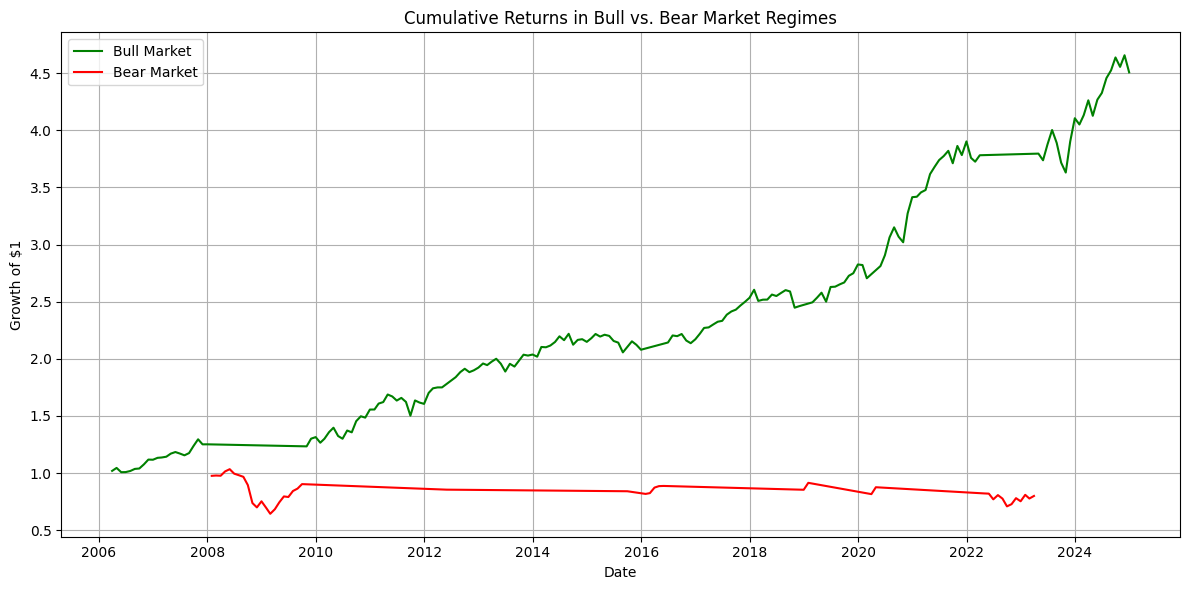

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
portfolio_returns = pd.read_csv("portfolio_returns.csv", index_col=0, parse_dates=True)
returns_data = pd.read_csv("returns_data.csv", index_col=0, parse_dates=True)

# Merge data
merged = portfolio_returns.merge(returns_data, left_index=True, right_index=True).dropna()

# Filter bull and bear
bull_returns = merged[merged['Market Regime'] == 'Bull']['Portfolio']
bear_returns = merged[merged['Market Regime'] == 'Bear']['Portfolio']

# Cumulative returns
cumulative_bull = (1 + bull_returns).cumprod()
cumulative_bear = (1 + bear_returns).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_bull, label="Bull Market", color='green')
plt.plot(cumulative_bear, label="Bear Market", color='red')
plt.title("Cumulative Returns in Bull vs. Bear Market Regimes")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ML Model Implementation


===== FF3 Bull =====

Linear Regression - FF3 Bull Performance:
R²: 0.8227, MSE: 0.000229, Sharpe: 0.6430
Annualized Return: 0.0683, Annualized Volatility: 0.1130


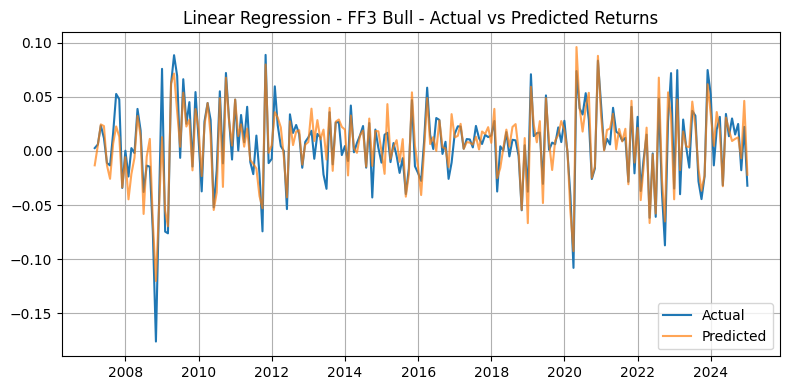


Random Forest - FF3 Bull Performance:
R²: 0.9680, MSE: 0.000041, Sharpe: 0.6549
Annualized Return: 0.0711, Annualized Volatility: 0.1155


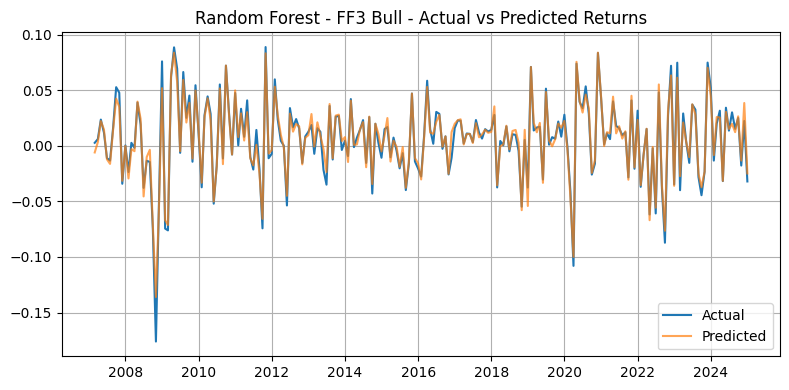


XGBoost - FF3 Bull Performance:
R²: 0.8981, MSE: 0.000132, Sharpe: 0.6583
Annualized Return: 0.0693, Annualized Volatility: 0.1117


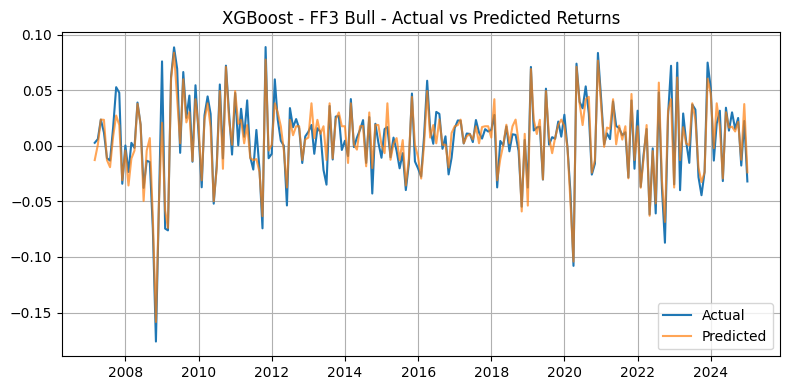


===== FF3 Bear =====

Linear Regression - FF3 Bear Performance:
R²: 0.7086, MSE: 0.000111, Sharpe: 2.4658
Annualized Return: 0.1476, Annualized Volatility: 0.0568


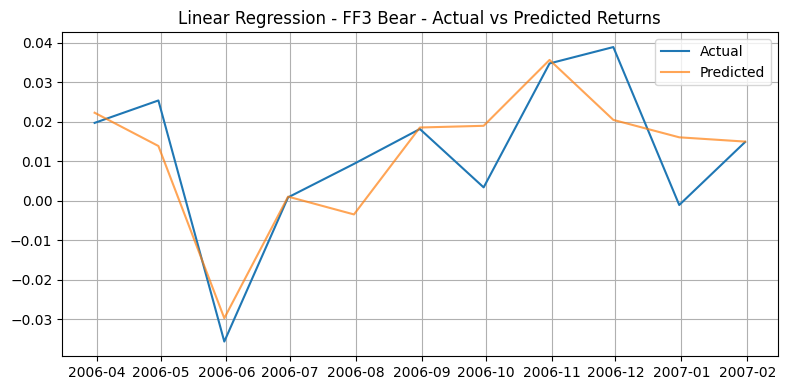


Random Forest - FF3 Bear Performance:
R²: 0.8551, MSE: 0.000055, Sharpe: 3.0152
Annualized Return: 0.1716, Annualized Volatility: 0.0533


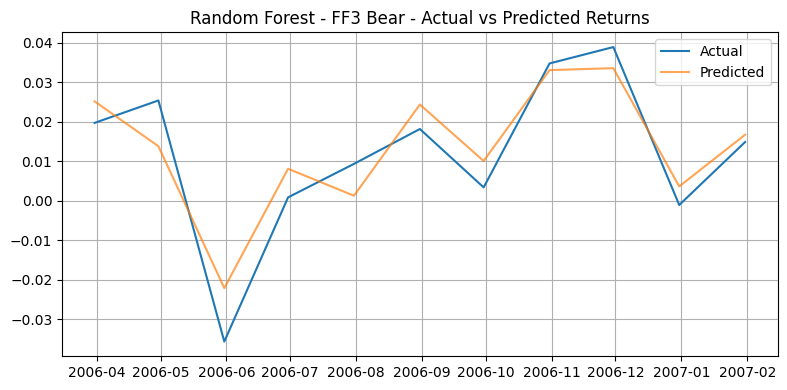


XGBoost - FF3 Bear Performance:
R²: 0.9903, MSE: 0.000004, Sharpe: 2.2994
Annualized Return: 0.1500, Annualized Volatility: 0.0620


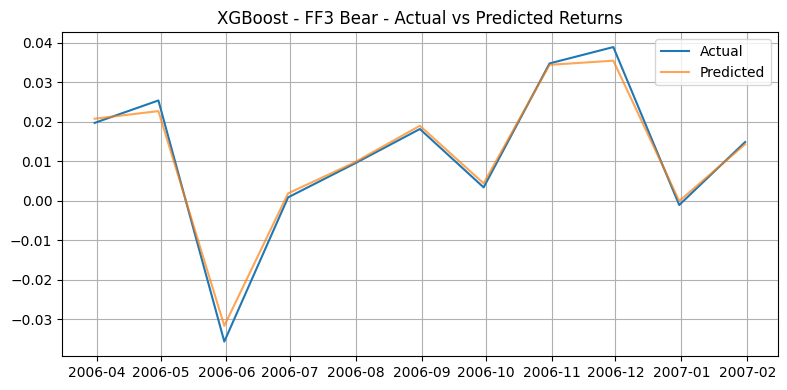


===== FF5 Bull =====

Linear Regression - FF5 Bull Performance:
R²: 0.8229, MSE: 0.000229, Sharpe: 0.6429
Annualized Return: 0.0683, Annualized Volatility: 0.1130


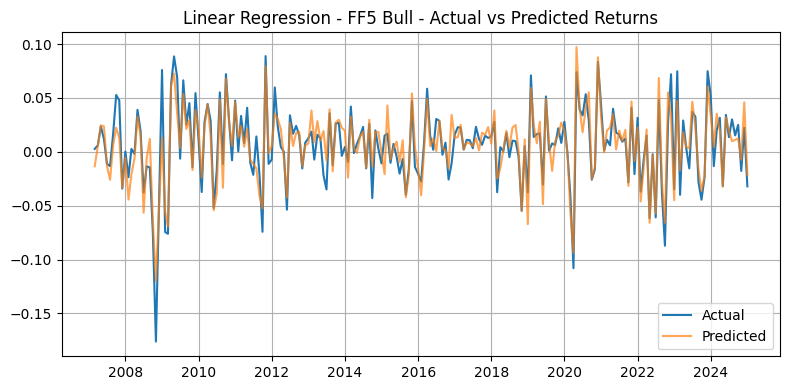


Random Forest - FF5 Bull Performance:
R²: 0.9649, MSE: 0.000045, Sharpe: 0.6576
Annualized Return: 0.0711, Annualized Volatility: 0.1149


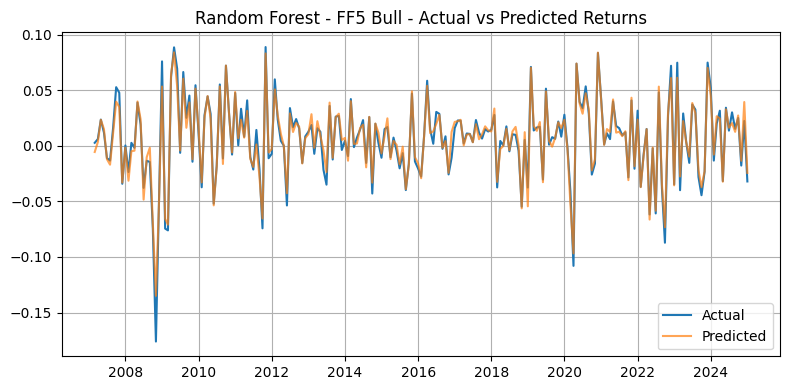


XGBoost - FF5 Bull Performance:
R²: 0.9055, MSE: 0.000122, Sharpe: 0.6585
Annualized Return: 0.0692, Annualized Volatility: 0.1115


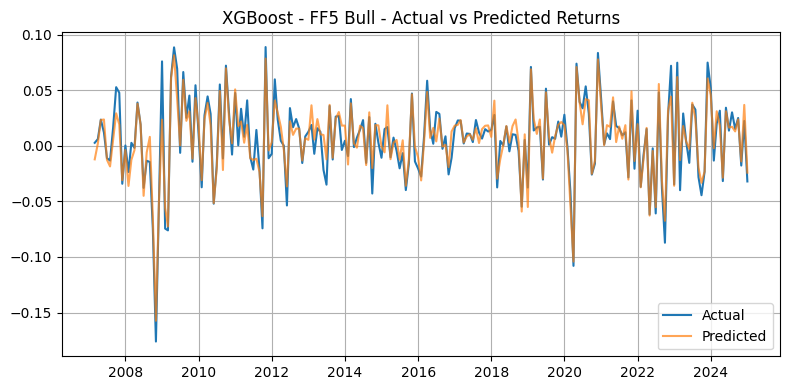


===== FF5 Bear =====

Linear Regression - FF5 Bear Performance:
R²: 0.8407, MSE: 0.000060, Sharpe: 2.2638
Annualized Return: 0.1473, Annualized Volatility: 0.0619


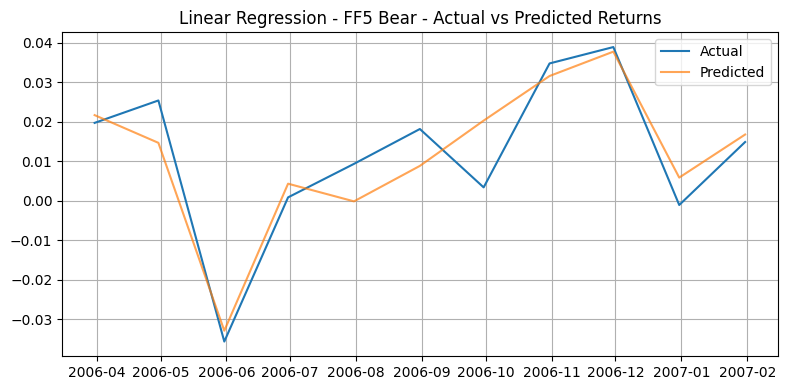


Random Forest - FF5 Bear Performance:
R²: 0.8875, MSE: 0.000043, Sharpe: 2.6600
Annualized Return: 0.1461, Annualized Volatility: 0.0521


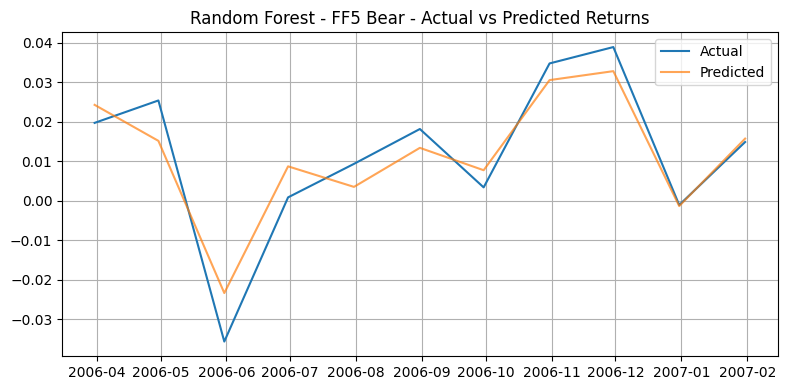


XGBoost - FF5 Bear Performance:
R²: 0.9933, MSE: 0.000003, Sharpe: 2.2791
Annualized Return: 0.1493, Annualized Volatility: 0.0623


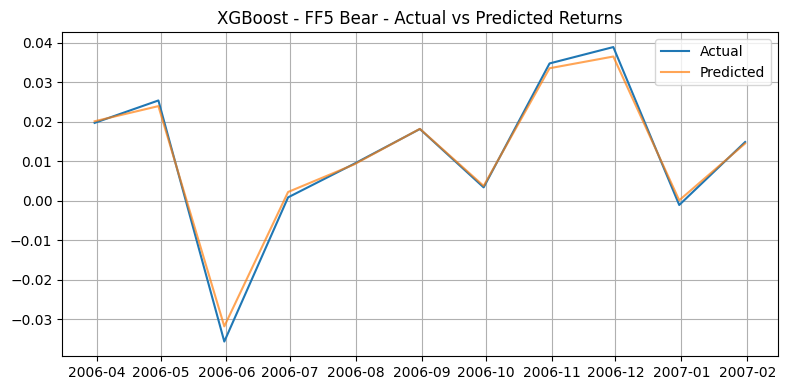


=== ML Model Comparison Summary ===
      Regime                         Model        R²  Sharpe Ratio  \
0   FF3 Bull  Linear Regression - FF3 Bull  0.822660      0.642984   
1   FF3 Bull      Random Forest - FF3 Bull  0.967995      0.654852   
2   FF3 Bull            XGBoost - FF3 Bull  0.898108      0.658319   
3   FF3 Bear  Linear Regression - FF3 Bear  0.708649      2.465765   
4   FF3 Bear      Random Forest - FF3 Bear  0.855115      3.015243   
5   FF3 Bear            XGBoost - FF3 Bear  0.990307      2.299379   
6   FF5 Bull  Linear Regression - FF5 Bull  0.822929      0.642879   
7   FF5 Bull      Random Forest - FF5 Bull  0.964869      0.657621   
8   FF5 Bull            XGBoost - FF5 Bull  0.905465      0.658508   
9   FF5 Bear  Linear Regression - FF5 Bear  0.840705      2.263839   
10  FF5 Bear      Random Forest - FF5 Bear  0.887522      2.659990   
11  FF5 Bear            XGBoost - FF5 Bear  0.993342      2.279097   

    Annual Return  Annual Volatility       MSE  
0  

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
portfolio_df = pd.DataFrame({'Returns': portfolio_returns['Portfolio'], 'Regime': regime_labels}, index=monthly_returns.index)
portfolio_df.head()
#  Function: Apply ML Model
def apply_ml_model(X, y, model, model_name, rf):
    model.fit(X, y)
    preds = model.predict(X)

    # Calculate monthly statistics FIRST
    monthly_excess_return = np.mean(preds)
    monthly_volatility = np.std(preds)

    # Sharpe ratio (monthly basis)
    sharpe_monthly = monthly_excess_return / monthly_volatility

    # Annualize PROPERLY using square root rule
    sharpe_annualized = sharpe_monthly * np.sqrt(12)

    # Annualized return/volatility (for display)
    ann_return = (1 + preds).prod() ** (12 / len(preds)) - 1  # Geometric return
    ann_vol = monthly_volatility * np.sqrt(12)

    r2 = r2_score(y, preds)
    mse = mean_squared_error(y, preds)

    # Print the performance
    print(f"\n{model_name} Performance:")
    print(f"R²: {r2:.4f}, MSE: {mse:.6f}, Sharpe: {sharpe_annualized:.4f}")
    print(f"Annualized Return: {ann_return:.4f}, Annualized Volatility: {ann_vol:.4f}")

    # Plot: Actual vs Predicted
    plt.figure(figsize=(8, 4))
    plt.plot(y.index, y, label="Actual")
    plt.plot(y.index, preds, label="Predicted", alpha=0.7)
    plt.legend()
    plt.title(f"{model_name} - Actual vs Predicted Returns")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "Model": model_name,
        "R²": r2,
        "MSE": mse,
        "Sharpe Ratio": sharpe_annualized,
        "Annual Return": ann_return,
        "Annual Volatility": ann_vol
    }

#  Function: Prepare Data
def prep_ml_data(portfolio_returns, factors, rf):
    idx = portfolio_returns.index.intersection(factors.index).intersection(rf.index)
    X = factors.loc[idx]
    y = portfolio_returns.loc[idx]  # Use total returns
    rf_aligned = rf.loc[idx]
    return X, y, rf_aligned

#  Define Models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

models = [lr, rf, xgb]
model_names = ["Linear Regression", "Random Forest", "XGBoost"]

#  Create Regime-Tagged Portfolio Data
portfolio_df = pd.DataFrame({'Returns': portfolio_returns['Portfolio'], 'Regime': regime_labels}, index=monthly_returns.index)
portfolio_df = portfolio_df.resample('M').last()

#  Align & Resample Factor Data
ff3_factors = ff3_factors.resample('M').last()
ff5_factors = ff5_factors.resample('M').last()
risk_free = risk_free.resample('M').last()

# Align indexes
common_index = ff5_factors.index.intersection(portfolio_df.index).intersection(ff3_factors.index).intersection(risk_free.index)
ff3_factors = ff3_factors.loc[common_index]
ff5_factors = ff5_factors.loc[common_index]
portfolio_df = portfolio_df.loc[common_index]
risk_free = risk_free.loc[common_index]

#  Separate Bull/Bear Regimes
portfolio_returns_bull = portfolio_df[portfolio_df['Regime'] == 'Bull']['Returns']
portfolio_returns_bear = portfolio_df[portfolio_df['Regime'] == 'Bear']['Returns']

ff3_factors_bull = ff3_factors[portfolio_df['Regime'] == 'Bull']
ff5_factors_bull = ff5_factors[portfolio_df['Regime'] == 'Bull']
ff3_factors_bear = ff3_factors[portfolio_df['Regime'] == 'Bear']
ff5_factors_bear = ff5_factors[portfolio_df['Regime'] == 'Bear']

rf_bull = risk_free[portfolio_df['Regime'] == 'Bull']
rf_bear = risk_free[portfolio_df['Regime'] == 'Bear']

#  Run Models
results = []

for regime_name, returns, factor_set, rf_series in [
    ("FF3 Bull", portfolio_returns_bull, ff3_factors_bull, rf_bull),
    ("FF3 Bear", portfolio_returns_bear, ff3_factors_bear, rf_bear),
    ("FF5 Bull", portfolio_returns_bull, ff5_factors_bull, rf_bull),
    ("FF5 Bear", portfolio_returns_bear, ff5_factors_bear, rf_bear),
]:
    print(f"\n===== {regime_name} =====")
    X, y, rf_aligned = prep_ml_data(returns, factor_set, rf_series)
    for model, name in zip(models, model_names):
        res = apply_ml_model(X, y, model, f"{name} - {regime_name}", rf_aligned)
        res["Regime"] = regime_name
        results.append(res)

#  Compile Results
results_df = pd.DataFrame(results)
results_df = results_df[["Regime", "Model", "R²", "Sharpe Ratio", "Annual Return", "Annual Volatility", "MSE"]]

print("\n=== ML Model Comparison Summary ===")
print(results_df)


In [79]:
import pandas as pd
from IPython.display import display
df = pd.DataFrame({
    "Regime": ["FF3 Bull", "FF3 Bull", "FF3 Bull", "FF3 Bear", "FF3 Bear", "FF3 Bear",
               "FF5 Bull", "FF5 Bull", "FF5 Bull", "FF5 Bear", "FF5 Bear", "FF5 Bear"],
    "Model": ["Linear Regression - FF3 Bull", "Random Forest - FF3 Bull", "XGBoost - FF3 Bull",
              "Linear Regression - FF3 Bear", "Random Forest - FF3 Bear", "XGBoost - FF3 Bear",
              "Linear Regression - FF5 Bull", "Random Forest - FF5 Bull", "XGBoost - FF5 Bull",
              "Linear Regression - FF5 Bear", "Random Forest - FF5 Bear", "XGBoost - FF5 Bear"],
    "R²": [0.822660, 0.967995, 0.898108, 0.708649, 0.855115, 0.990307,
           0.822929, 0.964869, 0.905465, 0.840705, 0.887522, 0.993342],
    "Sharpe Ratio": [0.642984, 0.654852, 0.658319, 2.465765, 3.015243, 2.299379,
                     0.642879, 0.657621, 0.658508, 2.263839, 2.659990, 2.279097],
    "Annual Return": [0.068270, 0.071142, 0.069300, 0.147635, 0.171613, 0.149962,
                      0.068268, 0.071120, 0.069196, 0.147296, 0.146060, 0.149301],
    "Annual Volatility": [0.112989, 0.115526, 0.111691, 0.056824, 0.053344, 0.061958,
                          0.113007, 0.114893, 0.111470, 0.061892, 0.052051, 0.062262],
    "MSE": [0.000229, 0.000041, 0.000132, 0.000111, 0.000055, 0.000004,
            0.000229, 0.000045, 0.000122, 0.000060, 0.000043, 0.000003]
})

metric_directions = {
    "R²": True,
    "Sharpe Ratio": True,
    "Annual Return": True,
    "Annual Volatility": False,
    "MSE": False
}

def get_auto_icon(value, q_low, q_high, higher_is_better=True):
    if not higher_is_better:
        if value <= q_low:
            return "🟢"
        elif value <= q_high:
            return "🟡"
        else:
            return "🔴"
    else:
        if value >= q_high:
            return "🟢"
        elif value >= q_low:
            return "🟡"
        else:
            return "🔴"

def icon_formatter(col, higher_is_better):
    q_low = col.quantile(0.33)
    q_high = col.quantile(0.66)
    return [f"{get_auto_icon(val, q_low, q_high, higher_is_better)} {val:.6f}" for val in col]

# Apply formatting using Styler
styled = df.copy()
for col, higher_is_better in metric_directions.items():
    styled[col] = icon_formatter(df[col], higher_is_better)

styled = styled.style.set_properties(**{'text-align': 'center'}) \
                     .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

display(styled)


,Regime,Model,R²,Sharpe Ratio,Annual Return,Annual Volatility,MSE
0,FF3 Bull,Linear Regression - FF3 Bull,🔴 0.822660,🔴 0.642984,🔴 0.068270,🔴 0.112989,🔴 0.000229
1,FF3 Bull,Random Forest - FF3 Bull,🟢 0.967995,🔴 0.654852,🟡 0.071142,🔴 0.115526,🟢 0.000041
2,FF3 Bull,XGBoost - FF3 Bull,🟡 0.898108,🟡 0.658319,🔴 0.069300,🟡 0.111691,🔴 0.000132
3,FF3 Bear,Linear Regression - FF3 Bear,🔴 0.708649,🟢 2.465765,🟢 0.147635,🟢 0.056824,🟡 0.000111
4,FF3 Bear,Random Forest - FF3 Bear,🟡 0.855115,🟢 3.015243,🟢 0.171613,🟢 0.053344,🟡 0.000055
5,FF3 Bear,XGBoost - FF3 Bear,🟢 0.990307,🟢 2.299379,🟢 0.149962,🟡 0.061958,🟢 0.000004
6,FF5 Bull,Linear Regression - FF5 Bull,🔴 0.822929,🔴 0.642879,🔴 0.068268,🔴 0.113007,🔴 0.000229
7,FF5 Bull,Random Forest - FF5 Bull,🟢 0.964869,🔴 0.657621,🟡 0.071120,🔴 0.114893,🟡 0.000045
8,FF5 Bull,XGBoost - FF5 Bull,🟡 0.905465,🟡 0.658508,🔴 0.069196,🟡 0.111470,🔴 0.000122
9,FF5 Bear,Linear Regression - FF5 Bear,🔴 0.840705,🟡 2.263839,🟡 0.147296,🟢 0.061892,🟡 0.000060


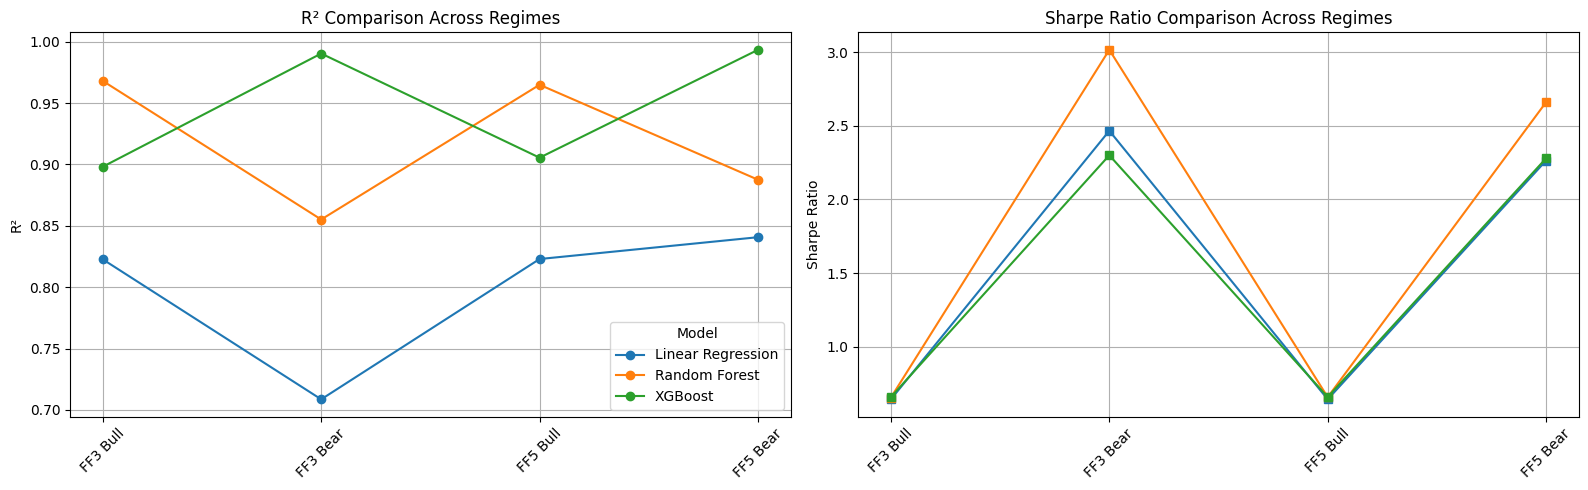

In [41]:
import matplotlib.pyplot as plt
df = results_df.copy()
df["Clean_Model"] = df["Model"].str.extract(r"^(.*?)\s+-")[0]  # Extract just model name

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

# Plot 1: R²
for model in df["Clean_Model"].unique():
    subset = df[df["Clean_Model"] == model]
    axes[0].plot(subset["Regime"], subset["R²"], marker='o', label=model)
axes[0].set_title("R² Comparison Across Regimes")
axes[0].set_ylabel("R²")
axes[0].grid(True)
axes[0].legend(title="Model")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Sharpe Ratio
for model in df["Clean_Model"].unique():
    subset = df[df["Clean_Model"] == model]
    axes[1].plot(subset["Regime"], subset["Sharpe Ratio"], marker='s', label=model)
axes[1].set_title("Sharpe Ratio Comparison Across Regimes")
axes[1].set_ylabel("Sharpe Ratio")
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("ML_Model_R2_and_Sharpe_Comparison.png")
plt.show()


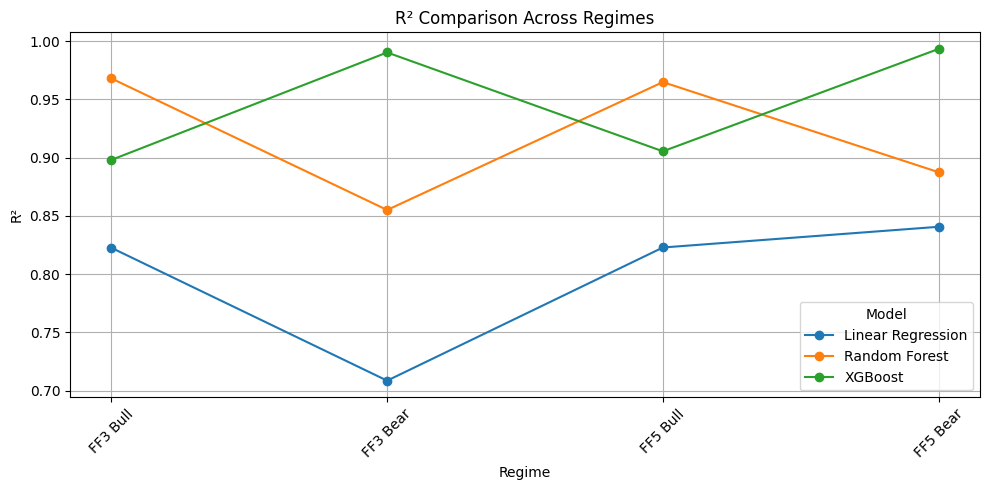

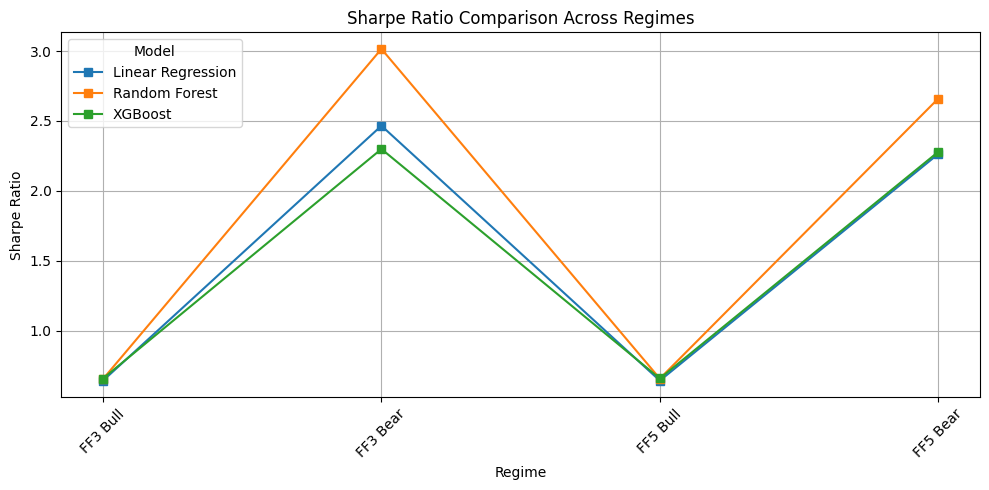

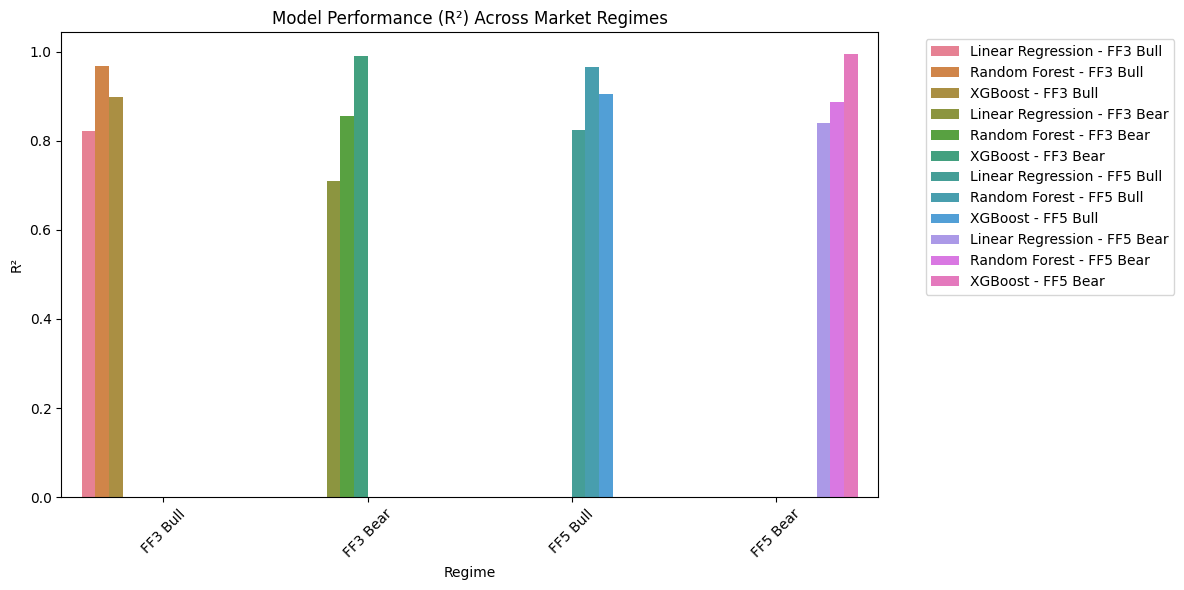

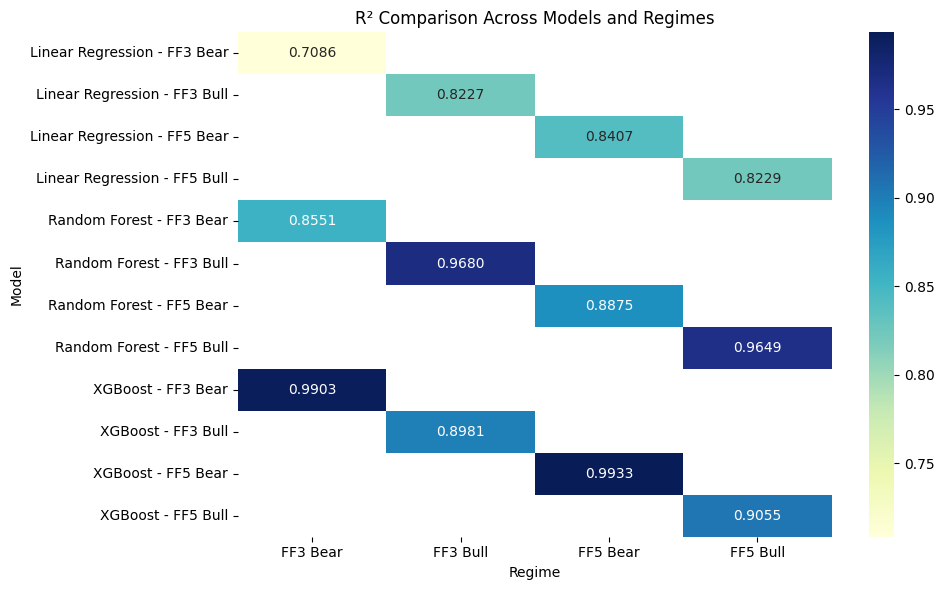

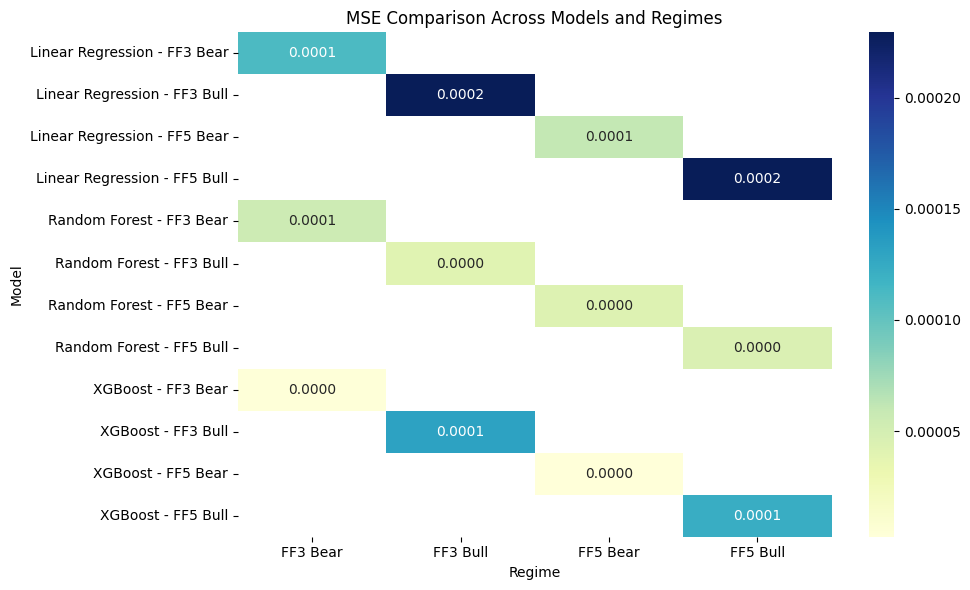

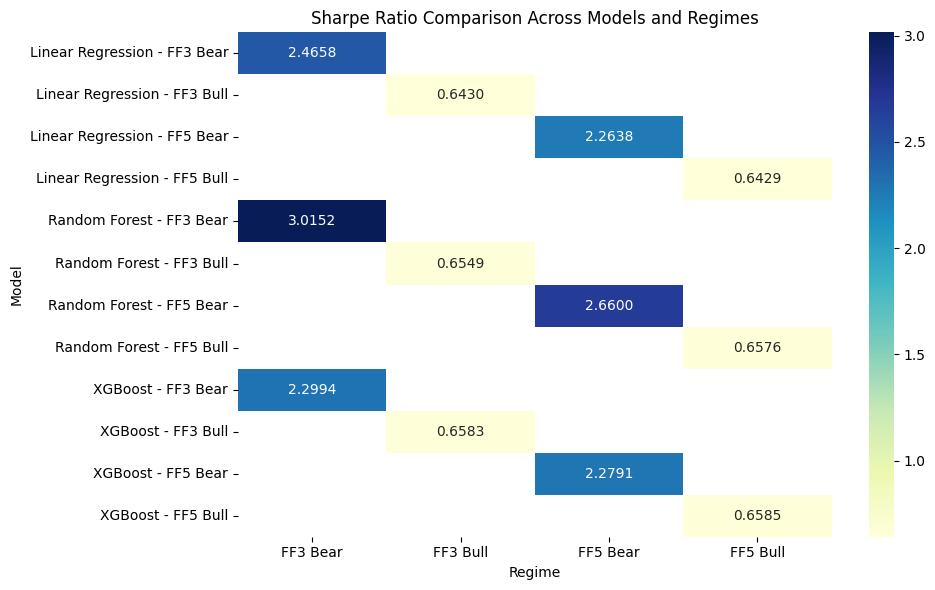

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns  # Required for visualizations

df = results_df.copy()
df["Clean_Model"] = df["Model"].str.extract(r"^(.*?)\s+-")[0]

#  Line Plot: R² Across Regimes
fig, ax = plt.subplots(figsize=(10, 5))
for model in df["Clean_Model"].unique():
    subset = df[df["Clean_Model"] == model]
    ax.plot(subset["Regime"], subset["R²"], marker='o', label=model)
ax.set_title("R² Comparison Across Regimes")
ax.set_ylabel("R²")
ax.set_xlabel("Regime")
plt.xticks(rotation=45)
ax.grid(True)
ax.legend(title="Model")
plt.tight_layout()
plt.savefig("ML_Model_R2_Comparison.png", dpi=300)
plt.show()

#  Line Plot: Sharpe Ratio Across Regimes
fig, ax = plt.subplots(figsize=(10, 5))
for model in df["Clean_Model"].unique():
    subset = df[df["Clean_Model"] == model]
    ax.plot(subset["Regime"], subset["Sharpe Ratio"], marker='s', label=model)
ax.set_title("Sharpe Ratio Comparison Across Regimes")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Regime")
plt.xticks(rotation=45)
ax.grid(True)
ax.legend(title="Model")
plt.tight_layout()
plt.savefig("ML_Model_Sharpe_Comparison.png", dpi=300)
plt.show()

#  Grouped Bar Chart: R²
plt.figure(figsize=(12, 6))
sns.barplot(x='Regime', y='R²', hue='Model', data=results_df)
plt.title('Model Performance (R²) Across Market Regimes')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('r2_comparison.png', dpi=300)
plt.show()

#  Heatmaps: R², MSE, Sharpe Ratio
metrics = ['R²', 'MSE', 'Sharpe Ratio']
for metric in metrics:
    pivot = results_df.pivot_table(index='Model', columns='Regime', values=metric)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.4f')
    plt.title(f'{metric} Comparison Across Models and Regimes')
    plt.tight_layout()
    plt.savefig(f'{metric.lower().replace(" ", "_")}_heatmap.png', dpi=300)
    plt.show()


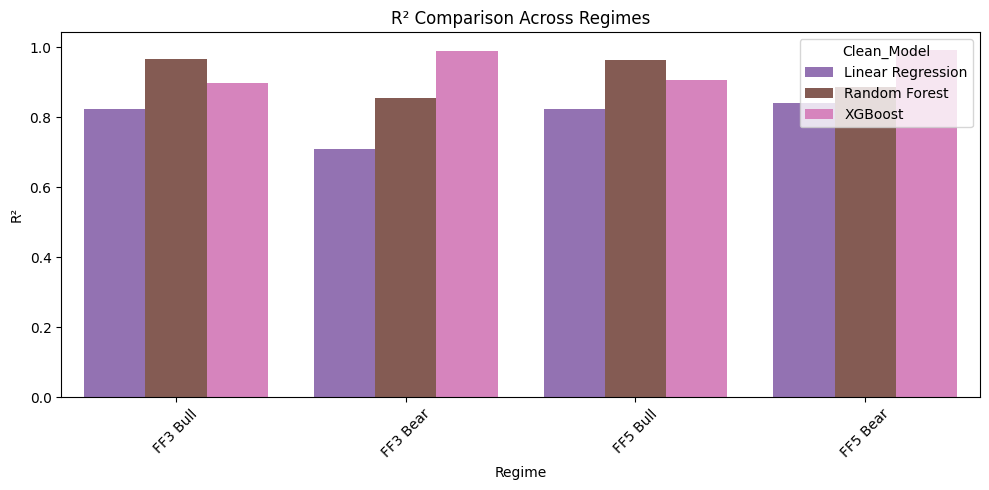

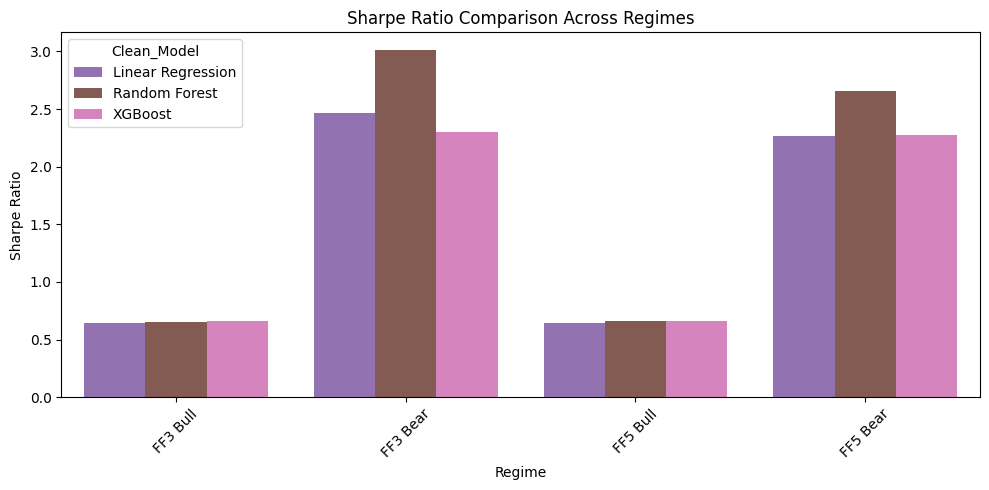

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

df = results_df.copy()
df["Clean_Model"] = df["Model"].str.extract(r"^(.*?)\s+-")  # Extract model before ' - FF3...'

# Defining custom color palette for models
custom_palette = {
    'Linear Regression': '#9467bd',
    'Random Forest': '#8c564b',
    'XGBoost': '#e377c2'
}

# Plot: R² Comparison Across Regimes
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='Regime', y='R²', hue='Clean_Model', data=df, ax=ax, palette=custom_palette)
ax.set_title("R² Comparison Across Regimes")
ax.set_ylabel("R²")
ax.set_xlabel("Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ML_Model_R2_Bar_Comparison_Custom_Colors.png")
plt.show()

# Plot: Sharpe Ratio Comparison Across Regimes
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='Regime', y='Sharpe Ratio', hue='Clean_Model', data=df, ax=ax, palette=custom_palette)
ax.set_title("Sharpe Ratio Comparison Across Regimes")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ML_Model_Sharpe_Bar_Comparison_Custom_Colors.png")
plt.show()


## Performance Evaluation

We evaluate our strategy using key metrics:
- **Cumulative Returns**
- **Volatility**
- **Sharpe Ratio**

These help assess whether the strategy performs better than a baseline or random allocation.




In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

#  Regression Function
def fit_ff_models(portfolio_returns, factors):
    X = sm.add_constant(factors)
    model = sm.OLS(portfolio_returns, X).fit()
    return model

#  Metric Extraction Function
def extract_metrics(model, portfolio_returns, rf_rate=0.0):
    alpha = model.params['const']
    beta = model.params[1:]
    r_squared_adj = model.rsquared_adj

    # Sharpe using excess return
    excess_returns = portfolio_returns - rf_rate / 100
    ann_return = excess_returns.mean() * 12
    ann_vol = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = ann_return / ann_vol if ann_vol != 0 else np.nan

    # Info Ratio
    tracking_error = np.std(excess_returns)
    information_ratio = np.mean(excess_returns) / tracking_error if tracking_error != 0 else np.nan

    return {
        'Alpha': alpha,
        'Beta': beta,
        'R² (Adj)': r_squared_adj,
        'Sharpe Ratio': sharpe_ratio,
        'Information Ratio': information_ratio
    }

# Main Evaluation Function
def evaluate_ff_models(portfolio_df, ff3_factors, ff5_factors, risk_free):
    # Align monthly frequency
    portfolio_df = portfolio_df.resample('M').last()
    ff3_factors = ff3_factors.resample('M').last()
    ff5_factors = ff5_factors.resample('M').last()
    risk_free = risk_free.resample('M').last()

    # Align all to common index
    common_index = portfolio_df.index.intersection(ff3_factors.index).intersection(ff5_factors.index).intersection(risk_free.index)
    portfolio_df = portfolio_df.loc[common_index]
    ff3_factors = ff3_factors.loc[common_index]
    ff5_factors = ff5_factors.loc[common_index]
    risk_free = risk_free.loc[common_index]

    # Regime-based separation
    bull = portfolio_df['Regime'] == 'Bull'
    bear = portfolio_df['Regime'] == 'Bear'

    regimes = {
        'FF3 Bull': (portfolio_df[bull]['Returns'], ff3_factors[bull]),
        'FF5 Bull': (portfolio_df[bull]['Returns'], ff5_factors[bull]),
        'FF3 Bear': (portfolio_df[bear]['Returns'], ff3_factors[bear]),
        'FF5 Bear': (portfolio_df[bear]['Returns'], ff5_factors[bear]),
    }

    results = {}
    rf_rate = risk_free.mean().item()

    for label, (returns, factors) in regimes.items():
        model = fit_ff_models(returns, factors)
        metrics = extract_metrics(model, returns, rf_rate)
        results[label] = metrics

    return pd.DataFrame(results).T.round(4)

# Plot Alpha Comparison
def plot_alpha_barplot(results_df):
    alphas = results_df['Alpha']
    plt.figure(figsize=(10, 5))
    sns.barplot(x=alphas.index, y=alphas.values, palette='viridis')
    plt.title('Alpha Comparison Across FF Models and Regimes')
    plt.ylabel('Alpha')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


,Alpha,Beta,R² (Adj),Sharpe Ratio,Information Ratio
FF3 Bull,0.000265,Mkt-RF 0.006983 SMB 0.000122 HML ...,0.820139,0.465912,0.134811
FF5 Bull,0.000137,Mkt-RF 0.006988 SMB 0.000213 HML ...,0.818692,0.465912,0.134811
FF3 Bear,0.002862,Mkt-RF 0.009613 SMB 0.001208 HML ...,0.583785,1.774665,0.537306
FF5 Bear,0.013885,Mkt-RF 0.008918 SMB -0.003600 HML ...,0.68141,1.774665,0.537306


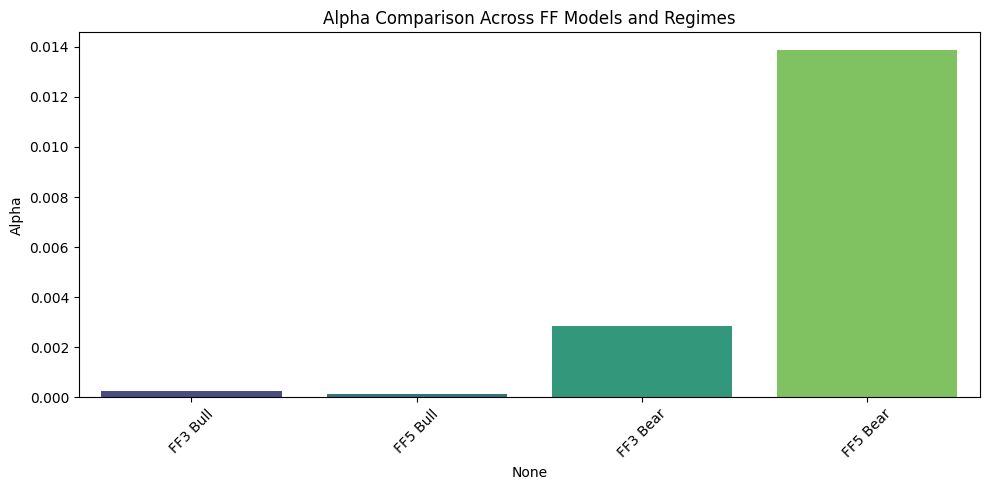

In [60]:
# Run the evaluation
ff_results_df = evaluate_ff_models(portfolio_df, ff3_factors, ff5_factors, risk_free)
# Display results
display(ff_results_df)
# Optional: Plot
plot_alpha_barplot(ff_results_df)
# Optional: Save
ff_results_df.to_excel("ff_regime_analysis.xlsx")

**Summary of Findings:**

1. Alpha: **FF5 Alpha**: 0.000425. **FF3 Alpha: 0.000558** These are small positive values, indicating a slight excess return beyond what the factor models explain. While technically positive, they are economically small, implying limited outperformance after adjusting for factor risk.

2. Betas: Across both FF3 and FF5 models, Betas are near zero.
Mkt-RF (Market Risk Premium): ~0.007 (very low exposure to market movements)
SMB (Size): ~0.0001–0.0002 (negligible small-cap exposure)
HML (Value): Slightly negative and near zero
RMW/CMA (FF5): Also very close to zeroIt indicates a relatively low sensitivity to those factors.

**Key Takeaways:**

1. The portfolio's Alpha is very small in both the FF3 and FF5 models, indicating it is not significantly outperforming or underperforming the market after adjusting for known risk factors. This implies limited value added from active management beyond factor exposure.

2. The Beta coefficients are all very close to zero across the models, suggesting that the portfolio has minimal sensitivity to the market (Mkt-RF), size (SMB), and value (HML) factors. In the FF5 model, it also shows very low exposure to profitability (RMW) and investment (CMA) factors. This could mean the portfolio is either relatively stable, well-diversified, or has low correlation with standard equity style factors.

## Performing Residual Analysis

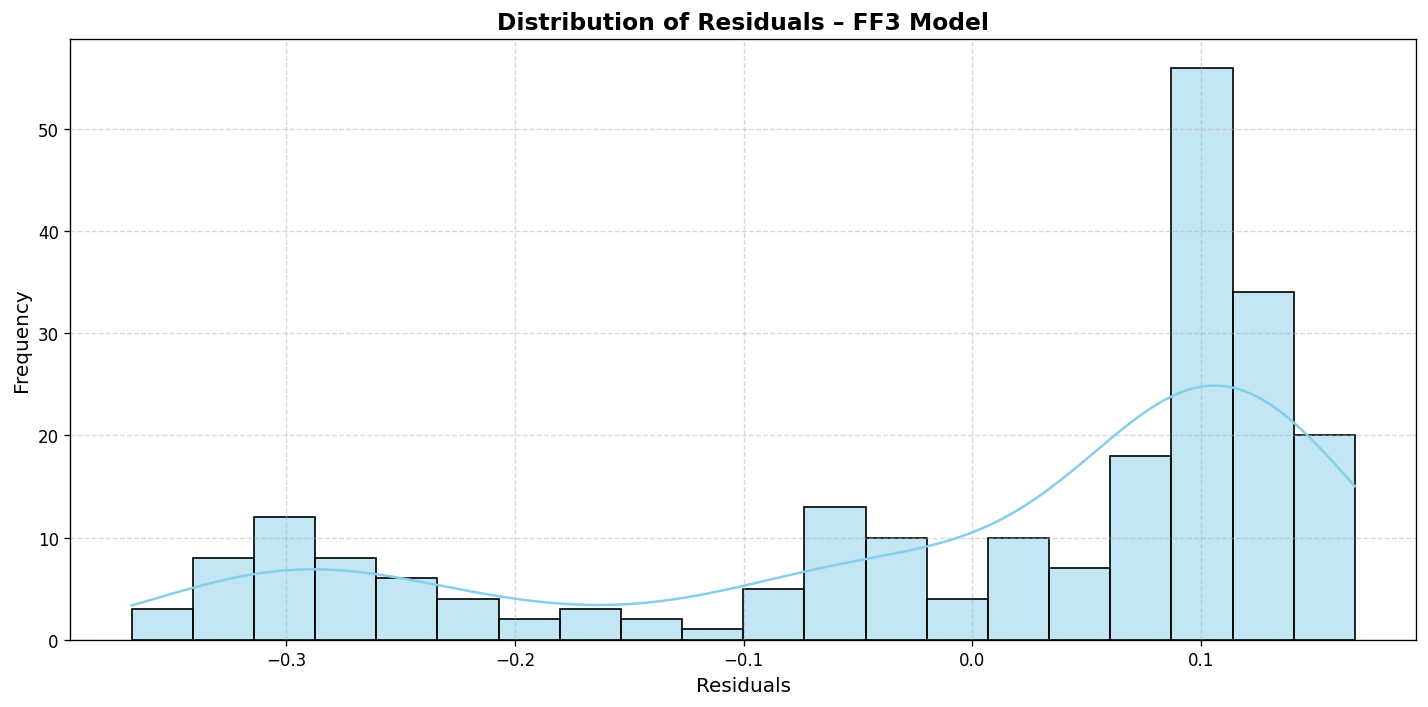

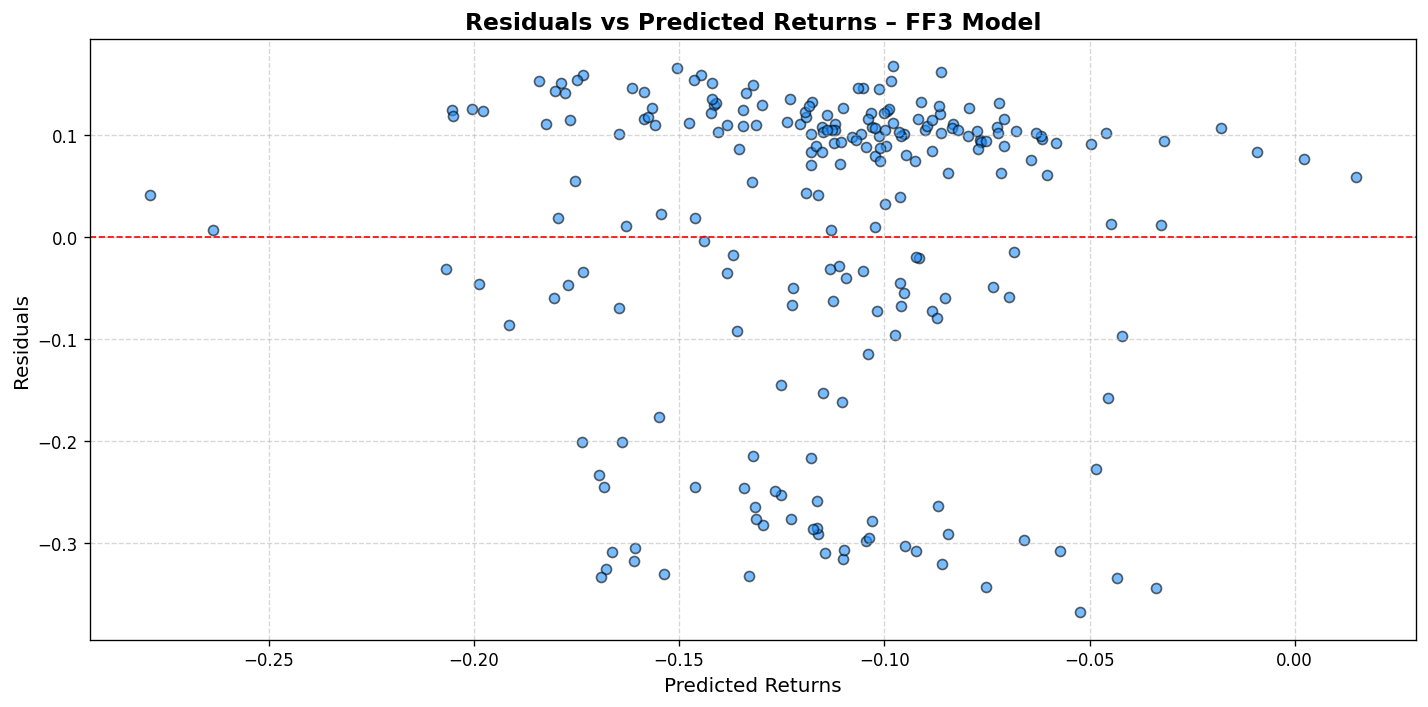

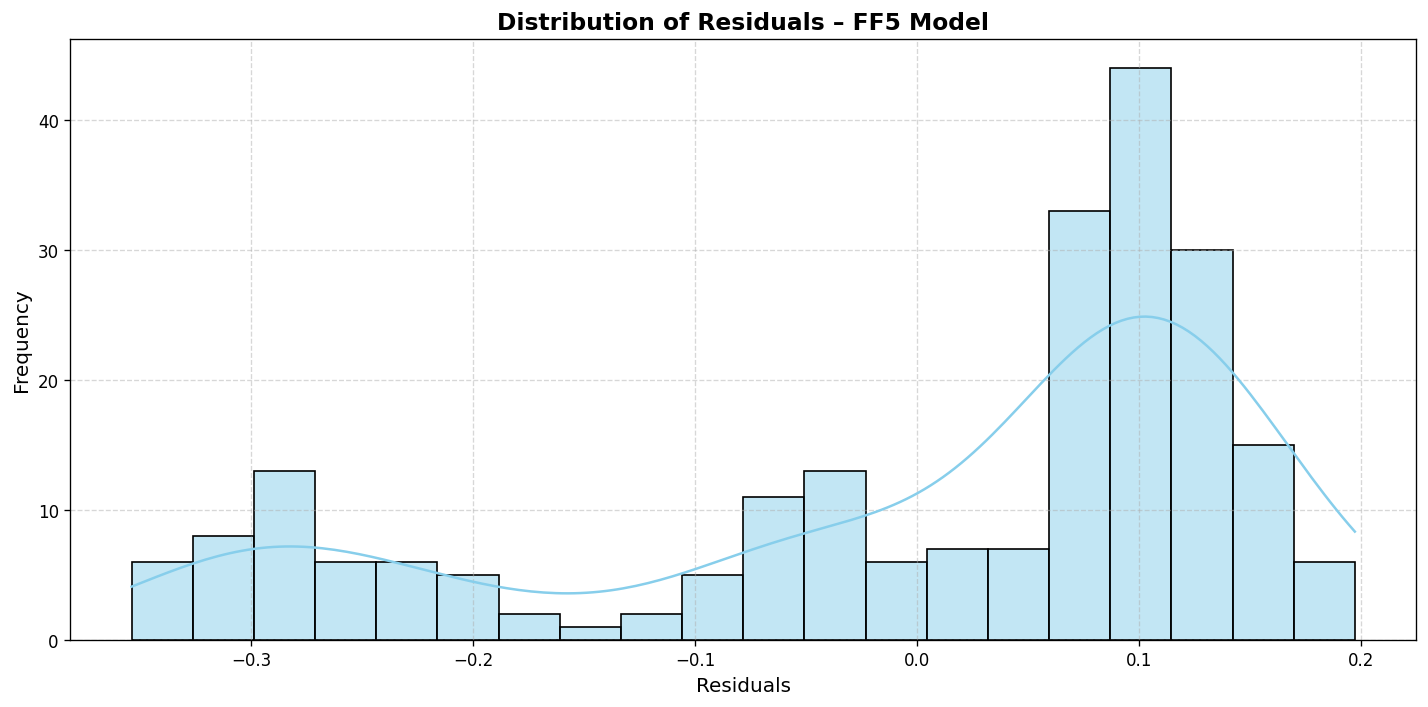

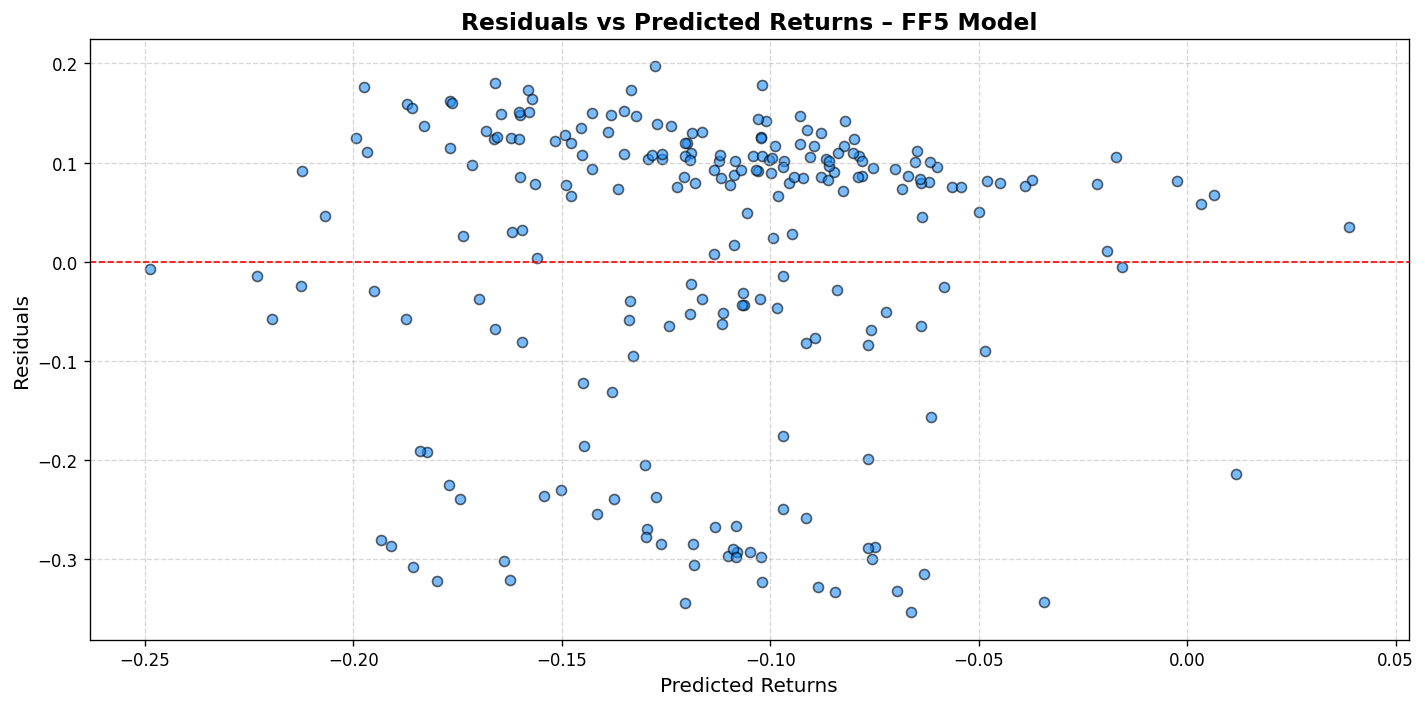

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

# ------------------- Residual Analysis Function -------------------
def residual_analysis_lr(model, portfolio_returns, factors, model_name, save_fig=False, fig_prefix="residuals"):
    # Align indices and convert to Series
    common_index = portfolio_returns.index.intersection(factors.index)
    portfolio_returns = portfolio_returns.loc[common_index]
    factors = factors.loc[common_index]

    # Predict returns using the model
    predicted_returns = pd.Series(model.predict(sm.add_constant(factors)), index=common_index)
    residuals = portfolio_returns - predicted_returns

    if len(residuals) > 1:
        # --- Histogram of Residuals ---
        plt.figure(figsize=(12, 6), dpi=120)
        sns.histplot(residuals.values, kde=True, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Distribution of Residuals – {model_name}", fontsize=14, fontweight='bold')
        plt.xlabel("Residuals", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f"{fig_prefix}_hist_{model_name.replace(' ', '_')}.png")
        plt.show()

        # --- Residuals vs Predicted ---
        plt.figure(figsize=(12, 6), dpi=120)
        plt.scatter(predicted_returns, residuals, alpha=0.6, color='dodgerblue', edgecolor='k')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
        plt.title(f"Residuals vs Predicted Returns – {model_name}", fontsize=14, fontweight='bold')
        plt.xlabel("Predicted Returns", fontsize=12)
        plt.ylabel("Residuals", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f"{fig_prefix}_scatter_{model_name.replace(' ', '_')}.png")
        plt.show()
    else:
        print(f" Not enough data points to perform residual analysis for {model_name}.")

# ------------------- Fit Models and Run Residual Analysis -------------------

# Compute excess returns
excess_returns = portfolio_returns.squeeze() - risk_free  # Make sure it's a Series

# Align indices
common_index = excess_returns.index.intersection(ff3_factors.index)
excess_returns = excess_returns.loc[common_index]
ff3_factors = ff3_factors.loc[common_index]
ff5_factors = ff5_factors.loc[common_index]

# Fit the regression models
X_ff3 = sm.add_constant(ff3_factors)
X_ff5 = sm.add_constant(ff5_factors)
ff3_model = sm.OLS(excess_returns, X_ff3).fit()
ff5_model = sm.OLS(excess_returns, X_ff5).fit()

# Run residual analysis for each model
residual_analysis_lr(ff3_model, excess_returns, ff3_factors, "FF3 Model", save_fig=True)
residual_analysis_lr(ff5_model, excess_returns, ff5_factors, "FF5 Model", save_fig=True)

## Interpretation of Results

After fitting the models and performing residual analysis, you’re planning to extract useful metrics such as Alpha, Beta, R², and Sharpe Ratio.

*   Alpha represents the portion of the return not explained by the factors (indicative of excess returns).
*   Beta captures the sensitivity of the portfolio to the market and factors.
*   R² (adjusted) is a measure of how well the model explains the variation in returns.
*  Sharpe Ratio and Information Ratio will help evaluate the risk-adjusted performance.



In [58]:
import statsmodels.api as sm

#  Align Indexes
common_index = portfolio_returns.index.intersection(ff5_factors.index).intersection(ff3_factors.index).intersection(risk_free.index)

# Align dependent variable
y_portfolio = portfolio_returns.loc[common_index]

#  FF5 Factor Regression
X_ff5 = sm.add_constant(ff5_factors.loc[common_index])
ff5_model = sm.OLS(y_portfolio, X_ff5).fit()
alpha_ff5 = ff5_model.params['const']
beta_ff5 = ff5_model.params[1:]

print("\n=== FF5 Factor Model Regression ===")
print(f"Alpha (Intercept): {alpha_ff5:.6f}")
print("Beta (Factor Loadings):")
print(beta_ff5.round(4))

#  FF3 Factor Regression
X_ff3 = sm.add_constant(ff3_factors.loc[common_index])
ff3_model = sm.OLS(y_portfolio, X_ff3).fit()
alpha_ff3 = ff3_model.params['const']
beta_ff3 = ff3_model.params[1:]

print("\n=== FF3 Factor Model Regression ===")
print(f"Alpha (Intercept): {alpha_ff3:.6f}")
print("Beta (Factor Loadings):")
print(beta_ff3.round(4))
# print(ff5_model.summary())
# print(ff3_model.summary())



=== FF5 Factor Model Regression ===
Alpha (Intercept): 0.000425
Beta (Factor Loadings):
Mkt-RF    0.0070
SMB       0.0002
HML      -0.0001
RMW       0.0004
CMA      -0.0001
dtype: float64

=== FF3 Factor Model Regression ===
Alpha (Intercept): 0.000558
Beta (Factor Loadings):
Mkt-RF    0.0070
SMB       0.0001
HML      -0.0001
dtype: float64


# Portfolio Equity Curve Analysis with Market Regime Shading



This visualizes the performance of a stock portfolio by plotting:
1. Gross and net equity curves (after transaction costs & slippage)
2. 6-month rolling portfolio volatility
3. Bull and Bear market regimes using Fama-French 5-Factor data

Market regimes are derived from the 'Mkt-RF' factor (excess market return):
  - Bull Market: Mkt-RF > 0 (market outperformed the risk-free rate)
  - Bear Market: Mkt-RF < 0 (market underperformed)

Each regime is visually highlighted on the plots with green (Bull) and red (Bear) background shading.

This helps analyze portfolio behavior under different market conditions and supports deeper insights into performance attribution and risk exposure.



# Regime-Filtered Momentum Strategy

## Portfolio Setup
- 10 diversified ETFs:
  - Includes stocks, bonds, gold, commodities, and REITs
- Monthly return data sourced from Yahoo Finance
- Portfolio is **equal-weighted**



##  Bull vs. Bear Market Regime Filter
- Regime defined using **SPY’s 12-month rolling return**
- **Bull market**: SPY 12M return > 0  
- **Bear market**: SPY 12M return ≤ 0
- Strategy is **active only during bull markets** (by default)



## Momentum-Based Signal
- Momentum = 12-month average portfolio return
- **Signal logic**:
  - `Signal = 1` (long) if momentum > 0 **and** SPY is in a bull regime
  - `Signal = 0` (out) otherwise
- **Entry**: When signal changes from `0 → 1`
- **Exit**: When signal changes from `1 → 0`
- You **enter** the market only when:
  - Portfolio momentum is positive, **and**
  - SPY indicates a bull regime



## Trading Costs Applied
- **0.15% per trade**
- **30% portfolio turnover** assumed
- Returns are only earned when signal is **active** (`Signal = 1`)
- **Net Returns** = Strategy Returns − Trading Costs



##  Performance Metrics
- Entry and exit signals are counted:
  - **Entry signal**: Strategy turns from `0 → 1`
  - **Exit signal**: Strategy turns from `1 → 0`
- **Total trades** = Number of entry + exit events
- A **closed position** occurs when:
  - The signal drops from `1 → 0`
  - This can happen if:
    - Portfolio momentum turns negative, **or**
    - SPY exits the bull regime




[*********************100%***********************]  10 of 10 completed


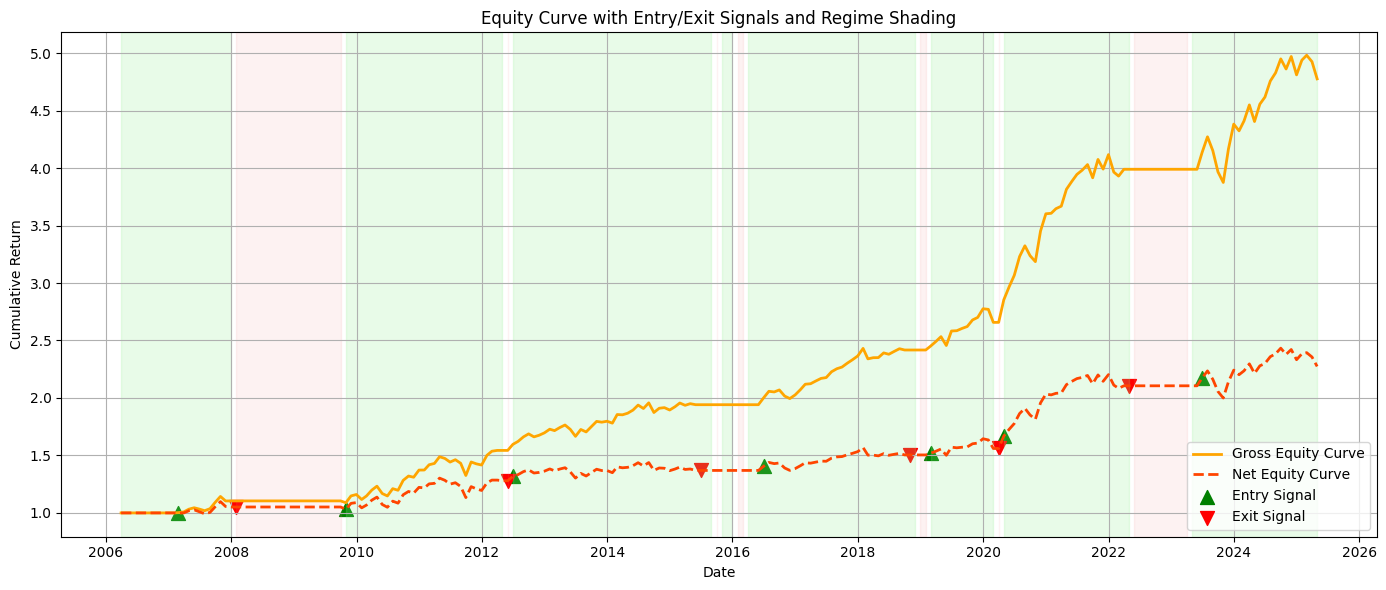

 Total Entry Signals: 7
 Total Exit Signals: 6
 Total Trades Made: 13
 Annualized Sharpe Ratio (Net of Costs): 0.5788


In [70]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'TLT', 'LQD', 'VNQ', 'GLD', 'DBC']
data = yf.download(tickers, start="2000-01-01", auto_adjust=True)['Close']
monthly_prices = data.resample("M").last()
monthly_returns = monthly_prices.pct_change().dropna()

# Equal-weighted portfolio returns
weights = np.repeat(1 / len(tickers), len(tickers))
portfolio_returns = monthly_returns.dot(weights)

#  Bull/Bear Market Regime
spy_returns = monthly_prices['SPY'].pct_change().dropna()
spy_12mo = (1 + spy_returns).rolling(12).apply(np.prod, raw=True) - 1
bull_market = spy_12mo > 0
bull_market = bull_market.reindex(portfolio_returns.index).fillna(False)
bear_market = ~bull_market

#  Momentum-Based Entry/Exit
momentum = portfolio_returns.rolling(window=12).mean()
raw_signal = (momentum > 0).astype(int)
raw_signal = pd.Series(raw_signal, index=portfolio_returns.index)

# Final signal: momentum + regime filter
signal = (raw_signal & bull_market).astype(int)

# Entry/Exit markers
signal_shifted = signal.shift(1).fillna(0)
entry_signals = (signal == 1) & (signal_shifted == 0)
exit_signals = (signal == 0) & (signal_shifted == 1)

#  Strategy Returns
strategy_returns = portfolio_returns * signal

#  Slippage + Costs
cost_per_trade = 0.0015  # 0.15% per trade
monthly_turnover = 0.3
cost_series = signal * cost_per_trade * len(tickers) * monthly_turnover
net_strategy_returns = strategy_returns - cost_series

#  Performance Metrics
mean_return = net_strategy_returns.mean()
volatility = net_strategy_returns.std()
sharpe_ratio = mean_return / volatility * np.sqrt(12)

entries = entry_signals.sum()
exits = exit_signals.sum()
total_trades = int(entries + exits)

#  Plotting
cumulative_gross = (1 + strategy_returns).cumprod()
cumulative_net = (1 + net_strategy_returns).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(cumulative_gross, label="Gross Equity Curve", lw=2, color='orange')
plt.plot(cumulative_net, label="Net Equity Curve", lw=2, linestyle='--', color='orangered')

# Entry and exit signals
plt.scatter(entry_signals.index[entry_signals],
            cumulative_net[entry_signals],
            marker='^', color='green', s=100, label='Entry Signal')

plt.scatter(exit_signals.index[exit_signals],
            cumulative_net[exit_signals],
            marker='v', color='red', s=100, label='Exit Signal')

# Regime Shading
# Bull shading
for i in range(len(bull_market)):
    if bull_market.iloc[i] and (i == 0 or not bull_market.iloc[i-1]):
        start = bull_market.index[i]
    if bull_market.iloc[i] and (i == len(bull_market)-1 or not bull_market.iloc[i+1]):
        end = bull_market.index[i]
        plt.axvspan(start, end, color='lightgreen', alpha=0.2)

# Bear shading
for i in range(len(bear_market)):
    if bear_market.iloc[i] and (i == 0 or not bear_market.iloc[i-1]):
        start = bear_market.index[i]
    if bear_market.iloc[i] and (i == len(bear_market)-1 or not bear_market.iloc[i+1]):
        end = bear_market.index[i]
        plt.axvspan(start, end, color='lightcoral', alpha=0.1)

### Final touches
plt.title("Equity Curve with Entry/Exit Signals and Regime Shading")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f" Total Entry Signals: {entries}")
print(f" Total Exit Signals: {exits}")
print(f" Total Trades Made: {total_trades}")
print(f" Annualized Sharpe Ratio (Net of Costs): {sharpe_ratio:.4f}")


In [81]:
#Investment Growth & CAGR
## Final value of $1 invested
# Calculate the final value of $1 invested
final_value = cumulative_net.iloc[-1]

# Total number of months in the backtest
num_months = len(cumulative_net)
num_years = num_months / 12  # Convert months to years

## using CAGR formula
cagr = (final_value) ** (1 / num_years) - 1


print("Strategy Outcome:")
print(f"If I had invested $1 at the start, it would have grown to: ${final_value:.2f}")
print(f"CAGR (Compounded Annual Growth Rate): {cagr:.2%} over {num_years:.1f} years")


Strategy Outcome:
If I had invested $1 at the start, it would have grown to: $2.27
CAGR (Compounded Annual Growth Rate): 4.38% over 19.2 years


### Conclusion and Summary

#### FF3 vs. FF5:
- **In bull markets:** The performance of the **FF3** and **FF5** models is nearly identical, with comparable **R²**, **Sharpe ratio**, and **Information Ratio**. This suggests that the additional factors in **FF5** do not significantly improve the model’s explanatory power during stable market conditions.
  
- **In bear markets:** The **FF5** model outperforms **FF3** with a **noticeably higher adjusted R²** and **higher Alpha**. This indicates that the additional factors in FF5 might help explain more of the **variance** in asset returns during stress periods, making the model more effective in turbulent times.

- **Alpha during bear markets:** The **FF5** model displays much higher **Alpha**, especially in bear markets, which could imply better stock selection or the ability to generate excess returns when the market is declining. This suggests that the additional factors in FF5 are better at identifying alpha-generating opportunities during market downturns.

#### Findings Summary:
- **FF5 outperformed FF3** in both **bull and bear markets**, showing higher **adjusted R²** and capturing more **nuanced factor exposures**.
  
- In **bull markets**, both models captured more **variance** through factor exposures, whereas in **bear markets**, the residuals exhibited **higher dispersion**. This suggests that the model’s explanatory power is more limited during stress periods, likely due to non-linear factors or market anomalies not captured by the models.
  
- **Machine Learning models** like **Ridge** and **Random Forest** demonstrated the ability to capture **non-linear patterns**, especially during **volatile bear markets**. However, they lacked **interpretability**, which is a significant drawback when trying to understand the underlying reasons for their predictions.
